In [1]:
import re
import datetime
import pathlib
import polars as pl # type: ignore
import matplotlib.pyplot as plt # type: ignore
from matplotlib.patches import Patch
import seaborn as sns # type: ignore
from upsetplot import UpSet, from_contents # type: ignore

In [2]:
VERSION = datetime.datetime.now().strftime("%y%m%d")
print(f"Execute Date: {VERSION}")

Execute Date: 250602


&nbsp;

&nbsp;

&nbsp;

## Parameters for papermill

In [3]:
foldseek_result_tsv = pathlib.Path("../Data/14_foldseek_result/foldseek_output_uniprot_rice_up_9606_tmalign.tsv")
rice_uniprot_idmapping_tsv = pathlib.Path("../Data/12_rice_uniprot_idmapping/rice_up_idmapping_all.tsv")
water_result_dir_path = "../Data/17_retrieve_sequence_rice_up/rice_up_tmalign/result_water_rice_up_tmalign"
needle_result_dir_path = "../Data/17_retrieve_sequence_rice_up/rice_up_tmalign/result_needle_rice_up_tmalign"
gene_list_tsv_path = "../Data/07_extract_gene/HN5_genelist_rice_2505/HN5_genes_up_rice.tsv"
togoid_convert_tsv_path = "../Data/18_togoid_convert_rice_up/togoid_convert_rice_up_rice_tmalign.tsv"
query_idmapping_tsv_path = "../Data/Data_uniprot/rice_up_idmapping_20241006.tsv"
target_idmapping_tsv_path = "../Data/Data_uniprot/rice_up_human_idmapping_20241006.tsv"
pan_homology_tsv_path = "../out/rice_up/202412_execute/rice_up_pan_homology_concat.tsv"

In [4]:
foldseek_result_df = pl.read_csv(
    foldseek_result_tsv,
    separator='\t'
)

foldseek_result = pl.read_csv(
    rice_uniprot_idmapping_tsv,
    separator='\t'
).join(
    foldseek_result_df,
    on="UniProt Accession",
    how="inner",
    coalesce=True
).drop(
    "taxlineage",
    "qaln",
    "taln",
    "lddtfull",
    "From_right"
).sort(
    by=["From", "foldseek hit", "UniProt Accession"], # sort by From, foldseek hit, UniProt Accession, qcov, lddt
    descending=[False, False, False]
).with_columns( # add foldseek hit ID for upset plot
    pl.struct(
        [
            "From",
            "foldseek hit",
            "UniProt Accession"
        ]
    ).rank("dense").alias("hit ID")
).with_columns( # assign label for upset plot
    (pl.lit("foldseek-hit-") + pl.col("hit ID").cast(pl.Utf8)).alias("hit label")
).drop(
    "hit ID"
).rename( # (from article) If Foldseek is used in TM-align mode (parameter --alignment-type 1), TM-align is used for the alignment stage after the prefilter step, where we replace the reported E-value column with TM-scores normalized by the query length.
    {
        "evalue" : "normalized TM-score"
    }
)


display(foldseek_result)

shape: (16_206, 27)
┌────────────┬────────────┬────────────┬────────────┬───┬───────┬───────────┬──────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ normalized ┆ … ┆ taxid ┆ taxname   ┆ mismatch ┆ hit label │
│ ---        ┆ Accession  ┆ hit        ┆ TM-score   ┆   ┆ ---   ┆ ---       ┆ ---      ┆ ---       │
│ str        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ i64   ┆ str       ┆ i64      ┆ str       │
│            ┆ str        ┆ str        ┆ f64        ┆   ┆       ┆           ┆          ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════╪═══════════╪══════════╪═══════════╡
│ Os01g01058 ┆ Q657Z2     ┆ A0A1B0GTK6 ┆ 0.7736     ┆ … ┆ 9606  ┆ Homo      ┆ 48       ┆ foldseek- │
│ 00         ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-1     │
│ Os01g01058 ┆ Q657Z2     ┆ Q5TBE9     ┆ 0.5569     ┆ … ┆ 9606  ┆ Homo      ┆ 38       ┆ foldseek- │
│ 00         ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-2     │
│ Os01g01058 ┆ Q657Z2     ┆ Q86U28     ┆ 0.6057     ┆ … ┆ 9606  ┆ Homo      ┆ 76       ┆ foldseek- │
│ 00         ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-3     │
│ Os01g01058 ┆ Q657Z2     ┆ Q9BUE6     ┆ 0.7425     ┆ … ┆ 9606  ┆ Homo      ┆ 51       ┆ foldseek- │
│ 00         ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-4     │
│ Os01g01358 ┆ Q943Q3     ┆ A0A024R3B9 ┆ 0.6343     ┆ … ┆ 9606  ┆ Homo      ┆ 75       ┆ foldseek- │
│ 00         ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-5     │
│ …          ┆ …          ┆ …          ┆ …          ┆ … ┆ …     ┆ …         ┆ …        ┆ …         │
│ gene-orf22 ┆ Q35317     ┆ Q6IB83     ┆ 0.1568     ┆ … ┆ 9606  ┆ Homo      ┆ 62       ┆ foldseek- │
│ 4          ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-16202 │
│ gene-orf22 ┆ Q35317     ┆ Q7Z5E6     ┆ 0.1621     ┆ … ┆ 9606  ┆ Homo      ┆ 70       ┆ foldseek- │
│ 4          ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-16203 │
│ gene-orf22 ┆ Q35317     ┆ Q8N799     ┆ 0.1673     ┆ … ┆ 9606  ┆ Homo      ┆ 59       ┆ foldseek- │
│ 4          ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-16204 │
│ gene-orf22 ┆ Q35317     ┆ Q9BXL7     ┆ 0.1477     ┆ … ┆ 9606  ┆ Homo      ┆ 99       ┆ foldseek- │
│ 4          ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-16205 │
│ gene-orf22 ┆ Q35317     ┆ Q9C0E8     ┆ 0.1907     ┆ … ┆ 9606  ┆ Homo      ┆ 82       ┆ foldseek- │
│ 4          ┆            ┆            ┆            ┆   ┆       ┆ sapiens   ┆          ┆ hit-16206 │
└────────────┴────────────┴────────────┴────────────┴───┴───────┴───────────┴──────────┴───────────┘

&nbsp;


### Structural alignment identical match vs LDDT

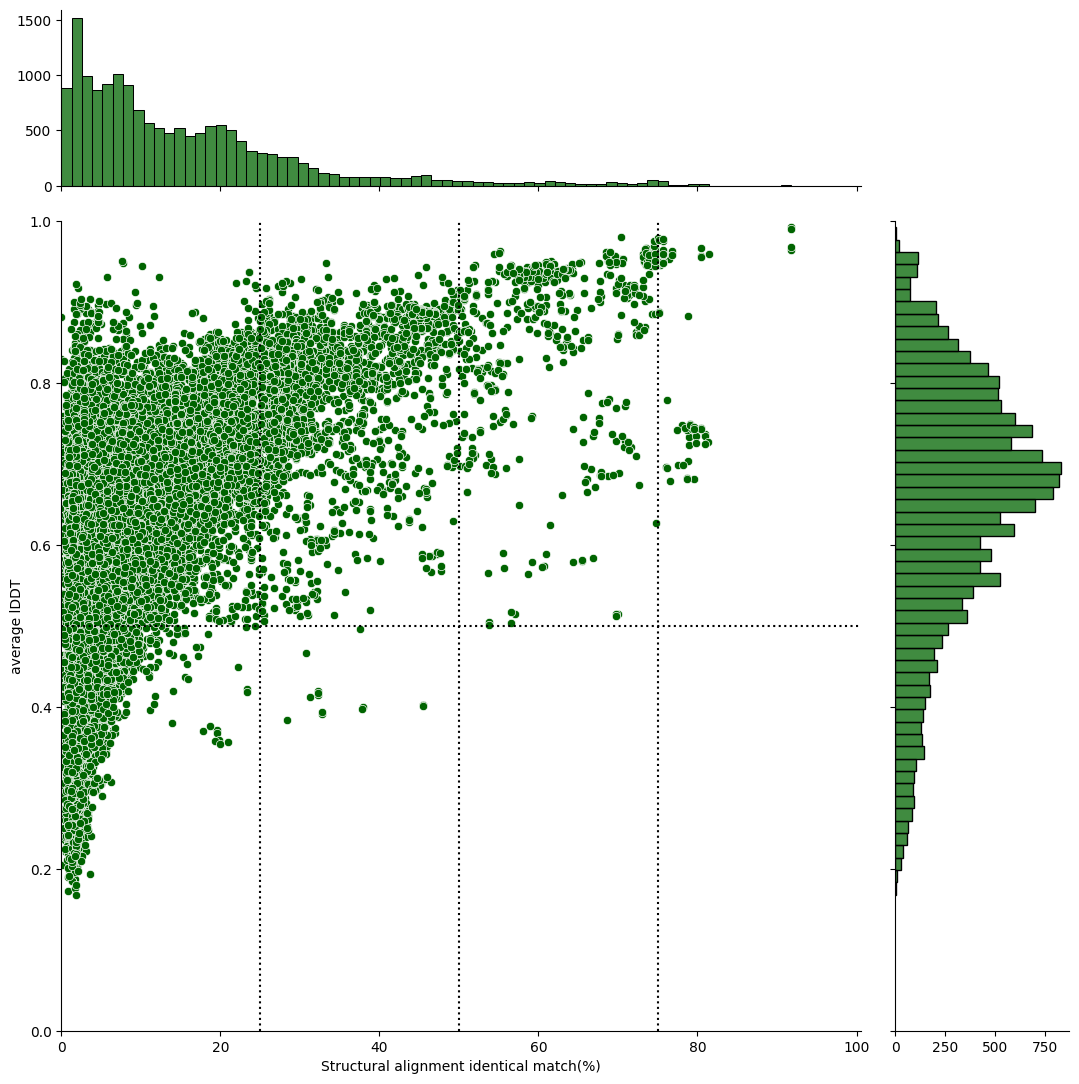

<Figure size 3200x3200 with 0 Axes>

In [5]:
foldseek_filter_viz = foldseek_result.to_pandas()
sns.jointplot(
    data=foldseek_filter_viz,
    x="pident", # structural alignment identical match from foldseek result
    y="lddt",
    color="darkgreen",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(0,100.5)
plt.ylim(0,1)
plt.xlabel("Structural alignment identical match(%)")
plt.ylabel("average lDDT") # see foldseek github https://github.com/steineggerlab/foldseek?tab=readme-ov-file#output-search
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(8, 8), dpi=400)
plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;

## Parse pairwise alignment result

In [6]:
def parse_needle_water_result(file_path: str):
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.readlines()
        
    result = {
        "UniProt Accession": None,
        "foldseek hit": None,
        "Length": None,
        "Identity": None,
        "Identity_percent": None,
        "Similarity": None,
        "Similarity_percent": None,
        "Gaps": None,
        "Gaps_percent": None,
        "Score": None
    }
    
    for line in data:
        if line.startswith('# 1:'):
            result['UniProt Accession'] = line.split(':')[1].strip()
        elif line.startswith('# 2:'):
            result['foldseek hit'] = line.split(':')[1].strip()
        elif line.startswith('# Length:'):
            result['Length'] = int(line.split()[2])
        elif line.startswith('# Identity:'):
            result['Identity'] = line.split()[2]
            result['Identity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Similarity:'):
            result['Similarity'] = line.split()[2]
            result['Similarity_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Gaps:'):
            result['Gaps'] = line.split()[2]
            result['Gaps_percent'] = float(re.search(r'\((.*?)%\)', line).group(1))
        elif line.startswith('# Score:'):
            result['Score'] = float(line.split()[2])
            
    return result

In [7]:
water_result_dir = pathlib.Path(water_result_dir_path)
needle_result_dir = pathlib.Path(needle_result_dir_path)

# Initialize empty lists to store DataFrames
water_dfs = []
needle_dfs = []

# Collect all water results
for result_file in water_result_dir.glob("*_align.water"):
    parsed_data = parse_needle_water_result(result_file)
    water_dfs.append(pl.DataFrame([parsed_data]))

# Collect all needle results    
for result_file in needle_result_dir.glob("*_align.needle"):
    parsed_data = parse_needle_water_result(result_file)
    needle_dfs.append(pl.DataFrame([parsed_data]))

# Combine all results and sort only if there are results
water_result = (pl.concat(water_dfs, how='vertical')
                .sort(["UniProt Accession", "foldseek hit"]) 
                if water_dfs else pl.DataFrame())

needle_result = (pl.concat(needle_dfs, how='vertical')
                 .sort(["UniProt Accession", "foldseek hit"])
                 if needle_dfs else pl.DataFrame())

display(water_result)
display(needle_result)

shape: (14_990, 10)
┌──────────────┬──────────────┬────────┬──────────┬───┬─────────────┬────────┬─────────────┬───────┐
│ UniProt      ┆ foldseek hit ┆ Length ┆ Identity ┆ … ┆ Similarity_ ┆ Gaps   ┆ Gaps_percen ┆ Score │
│ Accession    ┆ ---          ┆ ---    ┆ ---      ┆   ┆ percent     ┆ ---    ┆ t           ┆ ---   │
│ ---          ┆ str          ┆ i64    ┆ str      ┆   ┆ ---         ┆ str    ┆ ---         ┆ f64   │
│ str          ┆              ┆        ┆          ┆   ┆ f64         ┆        ┆ f64         ┆       │
╞══════════════╪══════════════╪════════╪══════════╪═══╪═════════════╪════════╪═════════════╪═══════╡
│ A0A0A0QMT5   ┆ A0A804HKW9   ┆ 163    ┆ 35/163   ┆ … ┆ 39.3        ┆ 28/163 ┆ 17.2        ┆ 66.5  │
│ A0A0A0QMT5   ┆ B7Z8A5       ┆ 101    ┆ 21/101   ┆ … ┆ 36.6        ┆ 28/101 ┆ 27.7        ┆ 45.5  │
│ A0A0A0QMT5   ┆ G3V154       ┆ 134    ┆ 28/134   ┆ … ┆ 36.6        ┆ 38/134 ┆ 28.4        ┆ 44.5  │
│ A0A0N7KCG6   ┆ A0A087WSV6   ┆ 90     ┆ 22/90    ┆ … ┆ 36.7        ┆ 24/90  ┆ 26.7        ┆ 40.5  │
│ A0A0N7KCG6   ┆ A0A0G2JM46   ┆ 214    ┆ 49/214   ┆ … ┆ 32.7        ┆ 72/214 ┆ 33.6        ┆ 43.5  │
│ …            ┆ …            ┆ …      ┆ …        ┆ … ┆ …           ┆ …      ┆ …           ┆ …     │
│ V5K4U5       ┆ Q7RTQ4       ┆ 184    ┆ 39/184   ┆ … ┆ 35.3        ┆ 47/184 ┆ 25.5        ┆ 62.0  │
│ V5K4U5       ┆ Q92953       ┆ 133    ┆ 30/133   ┆ … ┆ 34.6        ┆ 18/133 ┆ 13.5        ┆ 56.0  │
│ V5K4U5       ┆ Q96CF2       ┆ 214    ┆ 46/214   ┆ … ┆ 35.5        ┆ 53/214 ┆ 24.8        ┆ 55.0  │
│ V5K4U5       ┆ Q9BZ74       ┆ 183    ┆ 35/183   ┆ … ┆ 34.4        ┆ 41/183 ┆ 22.4        ┆ 59.5  │
│ V5K4U5       ┆ Q9NSK0       ┆ 190    ┆ 41/190   ┆ … ┆ 37.9        ┆ 54/190 ┆ 28.4        ┆ 72.5  │
└──────────────┴──────────────┴────────┴──────────┴───┴─────────────┴────────┴─────────────┴───────┘

shape: (14_990, 10)
┌─────────────┬─────────────┬────────┬──────────┬───┬─────────────┬──────────┬─────────────┬───────┐
│ UniProt     ┆ foldseek    ┆ Length ┆ Identity ┆ … ┆ Similarity_ ┆ Gaps     ┆ Gaps_percen ┆ Score │
│ Accession   ┆ hit         ┆ ---    ┆ ---      ┆   ┆ percent     ┆ ---      ┆ t           ┆ ---   │
│ ---         ┆ ---         ┆ i64    ┆ str      ┆   ┆ ---         ┆ str      ┆ ---         ┆ f64   │
│ str         ┆ str         ┆        ┆          ┆   ┆ f64         ┆          ┆ f64         ┆       │
╞═════════════╪═════════════╪════════╪══════════╪═══╪═════════════╪══════════╪═════════════╪═══════╡
│ A0A0A0QMT5  ┆ A0A804HKW9  ┆ 1240   ┆ 129/1240 ┆ … ┆ 17.5        ┆ 745/1240 ┆ 60.1        ┆ 45.5  │
│ A0A0A0QMT5  ┆ B7Z8A5      ┆ 997    ┆ 40/997   ┆ … ┆ 6.1         ┆ 870/997  ┆ 87.3        ┆ 13.5  │
│ A0A0A0QMT5  ┆ G3V154      ┆ 1014   ┆ 6/1014   ┆ … ┆ 1.0         ┆ 985/1014 ┆ 97.1        ┆ 19.0  │
│ A0A0N7KCG6  ┆ A0A087WSV6  ┆ 683    ┆ 49/683   ┆ … ┆ 10.7        ┆ 497/683  ┆ 72.8        ┆ 29.5  │
│ A0A0N7KCG6  ┆ A0A0G2JM46  ┆ 663    ┆ 55/663   ┆ … ┆ 13.0        ┆ 477/663  ┆ 71.9        ┆ 32.5  │
│ …           ┆ …           ┆ …      ┆ …        ┆ … ┆ …           ┆ …        ┆ …           ┆ …     │
│ V5K4U5      ┆ Q7RTQ4      ┆ 642    ┆ 40/642   ┆ … ┆ 12.1        ┆ 458/642  ┆ 71.3        ┆ 50.0  │
│ V5K4U5      ┆ Q92953      ┆ 912    ┆ 51/912   ┆ … ┆ 8.4         ┆ 713/912  ┆ 78.2        ┆ 35.5  │
│ V5K4U5      ┆ Q96CF2      ┆ 258    ┆ 49/258   ┆ … ┆ 31.0        ┆ 83/258   ┆ 32.2        ┆ 49.0  │
│ V5K4U5      ┆ Q9BZ74      ┆ 641    ┆ 49/641   ┆ … ┆ 13.3        ┆ 454/641  ┆ 70.8        ┆ 51.0  │
│ V5K4U5      ┆ Q9NSK0      ┆ 669    ┆ 45/669   ┆ … ┆ 11.2        ┆ 519/669  ┆ 77.6        ┆ 64.5  │
└─────────────┴─────────────┴────────┴──────────┴───┴─────────────┴──────────┴─────────────┴───────┘

In [8]:
alignment_result = water_result.join(
    needle_result,
    on=["UniProt Accession", "foldseek hit"],
    how="inner",
    coalesce=True,
    suffix="_needle"
).rename(
    {
        "Length": "Length_water",
        "Identity": "Identity_water",
        "Identity_percent": "Identity_percent_water",
        "Similarity": "Similarity_water",
        "Similarity_percent": "Similarity_percent_water",
        "Gaps": "Gaps_water",
        "Gaps_percent": "Gaps_percent_water",
        "Score": "Score_water"
    }
).select(
    [
        "UniProt Accession",
        "foldseek hit",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_needle",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_percent_water",
        "Gaps_needle",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
).sort(
    by=["UniProt Accession", "foldseek hit"],
    descending=[False, False]
)

display(alignment_result)

shape: (14_990, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ UniProt   ┆ foldseek  ┆ Length_wa ┆ Length_ne ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ Accession ┆ hit       ┆ ter       ┆ edle      ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ i64       ┆ i64       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ A0A0A0QMT ┆ A0A804HKW ┆ 163       ┆ 1240      ┆ … ┆ 745/1240  ┆ 60.1      ┆ 66.5      ┆ 45.5     │
│ 5         ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A0A0A0QMT ┆ B7Z8A5    ┆ 101       ┆ 997       ┆ … ┆ 870/997   ┆ 87.3      ┆ 45.5      ┆ 13.5     │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A0A0A0QMT ┆ G3V154    ┆ 134       ┆ 1014      ┆ … ┆ 985/1014  ┆ 97.1      ┆ 44.5      ┆ 19.0     │
│ 5         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A0A0N7KCG ┆ A0A087WSV ┆ 90        ┆ 683       ┆ … ┆ 497/683   ┆ 72.8      ┆ 40.5      ┆ 29.5     │
│ 6         ┆ 6         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ A0A0N7KCG ┆ A0A0G2JM4 ┆ 214       ┆ 663       ┆ … ┆ 477/663   ┆ 71.9      ┆ 43.5      ┆ 32.5     │
│ 6         ┆ 6         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ V5K4U5    ┆ Q7RTQ4    ┆ 184       ┆ 642       ┆ … ┆ 458/642   ┆ 71.3      ┆ 62.0      ┆ 50.0     │
│ V5K4U5    ┆ Q92953    ┆ 133       ┆ 912       ┆ … ┆ 713/912   ┆ 78.2      ┆ 56.0      ┆ 35.5     │
│ V5K4U5    ┆ Q96CF2    ┆ 214       ┆ 258       ┆ … ┆ 83/258    ┆ 32.2      ┆ 55.0      ┆ 49.0     │
│ V5K4U5    ┆ Q9BZ74    ┆ 183       ┆ 641       ┆ … ┆ 454/641   ┆ 70.8      ┆ 59.5      ┆ 51.0     │
│ V5K4U5    ┆ Q9NSK0    ┆ 190       ┆ 669       ┆ … ┆ 519/669   ┆ 77.6      ┆ 72.5      ┆ 64.5     │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;


&nbsp;

## Integrate foldseek result and pairwise alignment result

- This time, **exclude the ones that are null in pairwise alignment result, which means the current UniProt entry is obsolete**

In [9]:
join_foldseek = foldseek_result.join(
    alignment_result,
    on=["UniProt Accession", "foldseek hit"],
    how="left",
    coalesce=True
).filter( # filter out null alignment result (this means current UniProt entry is obsolete)
    pl.col("Length_water").is_not_null() & 
    pl.col("Length_needle").is_not_null()
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)


print(join_foldseek.group_by(["From"], maintain_order=True).n_unique())
display(join_foldseek)

shape: (211, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ Accession ┆ hit       ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ u32       ┆ u32       ┆ ---       ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32      │
│           ┆           ┆           ┆ u32       ┆   ┆           ┆ u32       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0105 ┆ 1         ┆ 4         ┆ 4         ┆ … ┆ 4         ┆ 4         ┆ 4         ┆ 4        │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ 1         ┆ 30        ┆ 30        ┆ … ┆ 25        ┆ 25      

shape: (14_990, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ Accession ┆ hit       ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ ---       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ 0.7736    ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ 800       ┆           ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q657Z2    ┆ Q5TBE9    ┆ 0.5569    ┆ … ┆ 58/141    ┆ 41.1      ┆ 154.5     ┆ 153.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ 0.6057    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ 0.7425    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ 0.6343    ┆ … ┆ 84/171    ┆ 49.1      ┆ 91.0      ┆ 84.0     │
│ 800       ┆           ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ gene-orf2 ┆ Q35317    ┆ Q6IB83    ┆ 0.1568    ┆ … ┆ 506/571   ┆ 88.6      ┆ 59.0      ┆ 32.0     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q7Z5E6    ┆ 0.1621    ┆ … ┆ 609/757   ┆ 80.4      ┆ 56.5      ┆ 30.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ 0.1673    ┆ … ┆ 461/489   ┆ 94.3      ┆ 34.0      ┆ 21.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q9BXL7    ┆ 0.1477    ┆ … ┆ 1274/1326 ┆ 96.1      ┆ 36.5      ┆ 24.0     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ 0.1907    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;

&nbsp;

## Create Scatter Plot for all hits

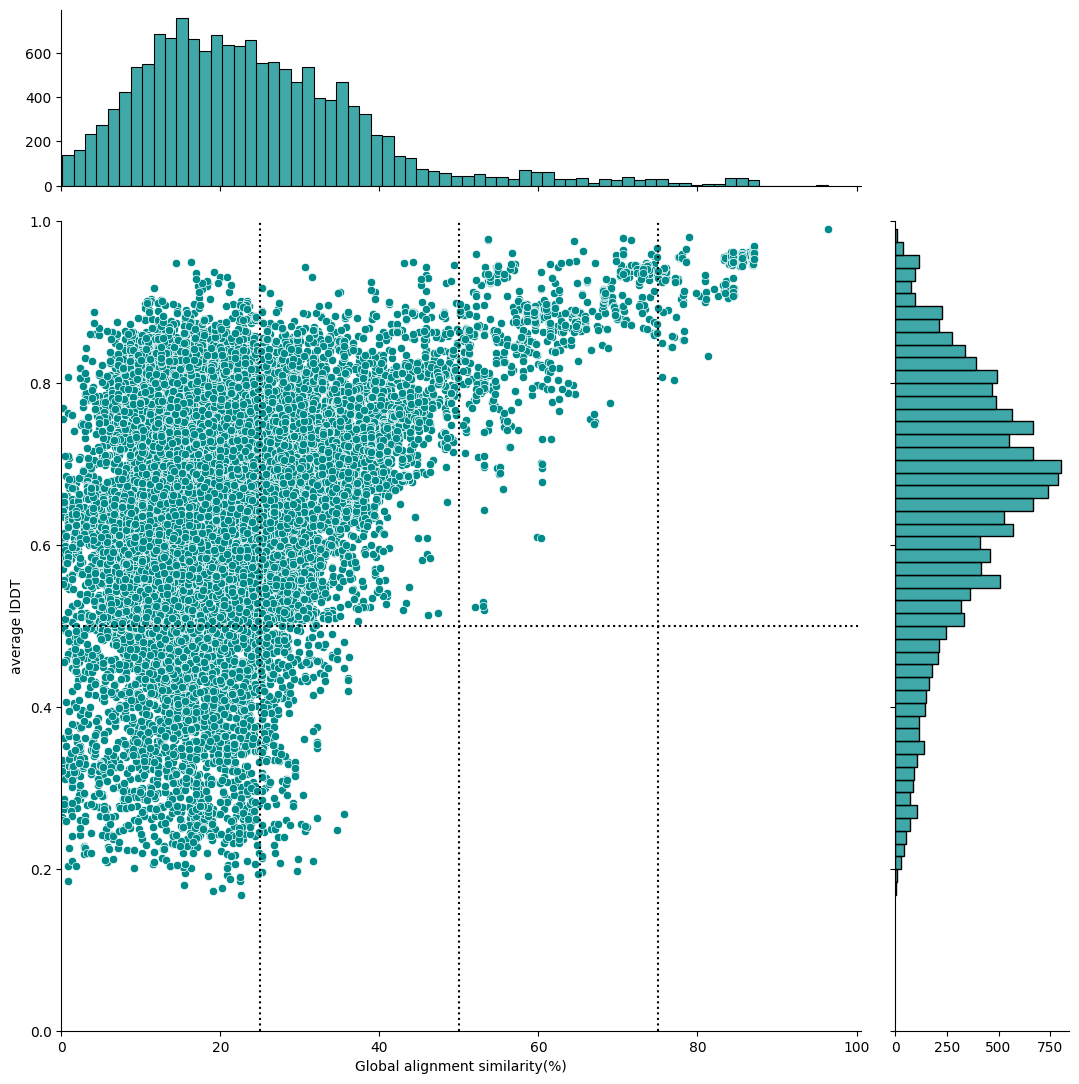

<Figure size 1500x1500 with 0 Axes>

In [10]:
foldseek_filter_viz2 = join_foldseek.to_pandas()

sns.jointplot(
    data=foldseek_filter_viz2,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(0,100.5)
plt.ylim(0,1)
plt.xlabel("Global alignment similarity(%)")
plt.ylabel("average lDDT") # see foldseek github https://github.com/steineggerlab/foldseek?tab=readme-ov-file#output-search
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(5, 5), dpi=300)
plt.show()

&nbsp;

&nbsp;


## (Experimental) figure that change y-axis to strucutural alignment target coverage


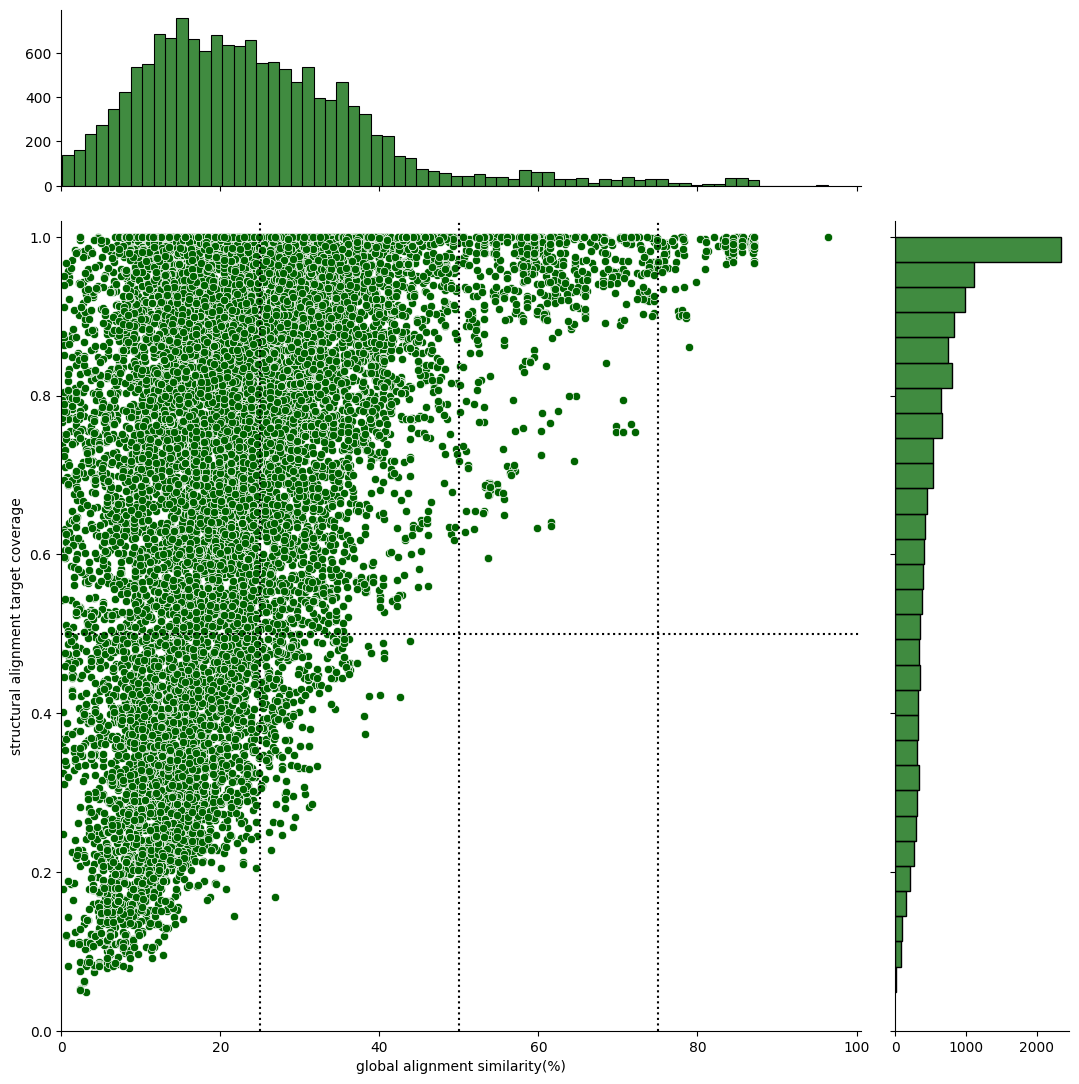

<Figure size 5000x5000 with 0 Axes>

In [11]:
sns.jointplot(
    data=foldseek_filter_viz2,
    x="Similarity_percent_needle",
    y="tcov",
    color="darkgreen",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(0,100.5)
plt.ylim(0,1.02)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("structural alignment target coverage")
plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
plt.figure(figsize=(10, 10), dpi=500)
plt.show()

&nbsp;

&nbsp;

&nbsp;


## Counting foldseek hits

- 遺伝子レベルで､foldseekでヒットがないものをカウントする

In [12]:
# 遺伝子レベルでのヒットカウントを算出
all_gene_list = pl.read_csv(
    gene_list_tsv_path,
    separator='\t'
).select(
    "From"
).unique()

hit_count = all_gene_list.join(
    join_foldseek,
    on="From",
    how="left",
    coalesce=True
).group_by("From", maintain_order=True).agg(
    (pl.col("foldseek hit").count().alias("target hit count (gene level vs uniprot accession)")),
    (pl.col("foldseek hit").is_null().all().alias("foldseek no hit"))
).sort(
    ["target hit count (gene level vs uniprot accession)"], descending=True
)

display(hit_count)
    
# hit_count.write_csv(
#     "../out/rice_down/foldseek_rice_down_hit_count.tsv",
#     separator='\t'
# )

no_hit_genes_list = hit_count.filter(
    pl.col("foldseek no hit") == True
)

idmapping_list = pl.read_csv(
    rice_uniprot_idmapping_tsv,
    separator='\t'
)
  
no_hit_idmapping_list = no_hit_genes_list.join(
    idmapping_list,
    on="From",
    how="left"
).sort(
    by=["From"],
    descending=[False]
)

print(no_hit_idmapping_list.group_by(["From"], maintain_order=True).n_unique())
display(no_hit_idmapping_list)

shape: (367, 3)
┌──────────────┬─────────────────────────────────┬─────────────────┐
│ From         ┆ target hit count (gene level v… ┆ foldseek no hit │
│ ---          ┆ ---                             ┆ ---             │
│ str          ┆ u32                             ┆ bool            │
╞══════════════╪═════════════════════════════════╪═════════════════╡
│ Os08g0442200 ┆ 524                             ┆ false           │
│ Os01g0699400 ┆ 497                             ┆ false           │
│ Os07g0633200 ┆ 462                             ┆ false           │
│ Os12g0600100 ┆ 454                             ┆ false           │
│ Os05g0223200 ┆ 434                             ┆ false           │
│ …            ┆ …                               ┆ …               │
│ Os02g0259850 ┆ 0                               ┆ true            │
│ Os08g0520600 ┆ 0                               ┆ true            │
│ Os04g0578550 ┆ 0                               ┆ true            │
│ Os08g0518800 ┆ 0                               ┆ true            │
│ Os12g0548401 ┆ 0                               ┆ true            │
└──────────────┴─────────────────────────────────┴─────────────────┘

shape: (156, 4)
┌──────────────┬─────────────────────────────────┬─────────────────┬───────────────────┐
│ From         ┆ target hit count (gene level v… ┆ foldseek no hit ┆ UniProt Accession │
│ ---          ┆ ---                             ┆ ---             ┆ ---               │
│ str          ┆ u32                             ┆ u32             ┆ u32               │
╞══════════════╪═════════════════════════════════╪═════════════════╪═══════════════════╡
│ Os01g0124000 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os01g0124100 ┆ 1                               ┆ 1               ┆ 2                 │
│ Os01g0124401 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os01g0136050 ┆ 1                               ┆ 1               ┆ 1                 │
│ Os01g0160800 ┆ 1                               ┆ 1               ┆ 3                 │
│ …            ┆ …                               ┆ …               ┆ …                 │
│ Os1

shape: (245, 4)
┌──────────────┬─────────────────────────────────┬─────────────────┬───────────────────┐
│ From         ┆ target hit count (gene level v… ┆ foldseek no hit ┆ UniProt Accession │
│ ---          ┆ ---                             ┆ ---             ┆ ---               │
│ str          ┆ u32                             ┆ bool            ┆ str               │
╞══════════════╪═════════════════════════════════╪═════════════════╪═══════════════════╡
│ Os01g0124000 ┆ 0                               ┆ true            ┆ Q5ZCB1            │
│ Os01g0124000 ┆ 0                               ┆ true            ┆ Q5ZD53            │
│ Os01g0124100 ┆ 0                               ┆ true            ┆ A0A0P0UYB2        │
│ Os01g0124100 ┆ 0                               ┆ true            ┆ Q0JR27            │
│ Os01g0124401 ┆ 0                               ┆ true            ┆ Q0JR25            │
│ …            ┆ …                               ┆ …               ┆ …                 │
│ Os12g0548401 ┆ 0                               ┆ true            ┆ Q2QNZ6            │
│ Os12g0548700 ┆ 0                               ┆ true            ┆ B9GDL9            │
│ Os12g0548700 ┆ 0                               ┆ true            ┆ Q2QNZ3            │
│ Os12g0569200 ┆ 0                               ┆ true            ┆ C7JA73            │
│ Os12g0569200 ┆ 0                               ┆ true            ┆ Q2QND9            │
└──────────────┴─────────────────────────────────┴─────────────────┴───────────────────┘

&nbsp;

&nbsp;

## Filtering Condition1

- query coverage が 0.5以上, target coverage が 0.5以上のものを選抜する
- (これまでのcondition3の処理を先に行う)

In [13]:
condition1 = join_foldseek.filter(
        (pl.col("qcov") >= 0.5) &
        (pl.col("tcov") >= 0.5)
    ).sort(
        by=["From", "foldseek hit", "UniProt Accession"], # sort by From, foldseek hit, UniProt Accession
        descending=[False, False, False]
    )

condition1_rm = condition1.filter(
        (pl.col("qcov") < 0.5) |
        (pl.col("tcov") < 0.5)
    )

print(condition1.group_by(["From"], maintain_order=True).n_unique())
pl.Config.set_tbl_rows(10)
display(condition1)

shape: (200, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ Accession ┆ hit       ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ u32       ┆ u32       ┆ ---       ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32      │
│           ┆           ┆           ┆ u32       ┆   ┆           ┆ u32       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0105 ┆ 1         ┆ 3         ┆ 3         ┆ … ┆ 3         ┆ 3         ┆ 3         ┆ 3        │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ 1         ┆ 19        ┆ 19        ┆ … ┆ 16        ┆ 16      

shape: (10_545, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ Accession ┆ hit       ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ ---       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ 0.7736    ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ 800       ┆           ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ 0.6057    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ 0.7425    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ 0.6343    ┆ … ┆ 84/171    ┆ 49.1      ┆ 91.0      ┆ 84.0     │
│ 800       ┆           ┆ 9         ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ A0A140G96 ┆ 0.5415    ┆ … ┆ 56/187    ┆ 29.9      ┆ 91.0      ┆ 80.5     │
│ 800       ┆           ┆ 1         ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ gene-orf2 ┆ Q35317    ┆ Q6AHX7    ┆ 0.1599    ┆ … ┆ 76/273    ┆ 27.8      ┆ 56.0      ┆ 27.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q6AZY7    ┆ 0.1337    ┆ … ┆ 436/633   ┆ 68.9      ┆ 85.0      ┆ 62.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q7Z5E6    ┆ 0.1621    ┆ … ┆ 609/757   ┆ 80.4      ┆ 56.5      ┆ 30.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ 0.1673    ┆ … ┆ 461/489   ┆ 94.3      ┆ 34.0      ┆ 21.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ 0.1907    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;


## Filtering Condition2

- 同じ遺伝子由来のUniProt IDに対して､同じtargetのヒットがある場合､qcovが最も高いものを選抜し，qcovが同じ場合はlddtが最も高いものを選抜する
- **本研究では，イネの遺伝子が異なっていても，同じfoldseek hitがある状態は残していることに注意**

In [14]:
condition2 = condition1.sort(
    by=["qcov", "lddt"],
    descending=[True, True]
).group_by(
    ["From", "foldseek hit"],
    maintain_order=True
).agg(
    pl.all().first()
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)

condition2_checked = condition2.filter(
    pl.col("foldseek hit") == "X6R9L0"
)

display(condition2_checked)
display(condition2)

shape: (2, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ foldseek  ┆ UniProt   ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ hit       ┆ Accession ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ ---       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os02g0644 ┆ X6R9L0    ┆ Q6H660    ┆ 0.2818    ┆ … ┆ 339/685   ┆ 49.5      ┆ 178.5     ┆ 160.0    │
│ 100       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os05g0156 ┆ X6R9L0    ┆ B9FHF3    ┆ 0.2119    ┆ … ┆ 568/684   ┆ 83.0      ┆ 176.0     ┆ 148.0    │
│ 500       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

shape: (8_071, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ foldseek  ┆ UniProt   ┆ normalize ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ hit       ┆ Accession ┆ d         ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ ---       ┆ ---       ┆ TM-score  ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆ str       ┆ str       ┆ ---       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆ f64       ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0105 ┆ A0A1B0GTK ┆ Q657Z2    ┆ 0.7736    ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ 800       ┆ 6         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q86U28    ┆ Q657Z2    ┆ 0.6057    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0105 ┆ Q9BUE6    ┆ Q657Z2    ┆ 0.7425    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ 800       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ A0A024R3B ┆ Q943Q3    ┆ 0.6343    ┆ … ┆ 84/171    ┆ 49.1      ┆ 91.0      ┆ 84.0     │
│ 800       ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ A0A140G96 ┆ Q943Q3    ┆ 0.5415    ┆ … ┆ 56/187    ┆ 29.9      ┆ 91.0      ┆ 80.5     │
│ 800       ┆ 1         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ gene-orf2 ┆ Q6AHX7    ┆ Q35317    ┆ 0.1599    ┆ … ┆ 76/273    ┆ 27.8      ┆ 56.0      ┆ 27.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q6AZY7    ┆ Q35317    ┆ 0.1337    ┆ … ┆ 436/633   ┆ 68.9      ┆ 85.0      ┆ 62.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q7Z5E6    ┆ Q35317    ┆ 0.1621    ┆ … ┆ 609/757   ┆ 80.4      ┆ 56.5      ┆ 30.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q8N799    ┆ Q35317    ┆ 0.1673    ┆ … ┆ 461/489   ┆ 94.3      ┆ 34.0      ┆ 21.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ gene-orf2 ┆ Q9C0E8    ┆ Q35317    ┆ 0.1907    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ 24        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;


## Filtering Condition3

- TogoIDでEnsembl gene idに変換できるヒットを選抜する
- おそらく1つのUniProt IDに対して，複数のgene IDが対応している可能性がある

In [15]:
togoid_convert = pl.read_csv(
    togoid_convert_tsv_path,
    separator='\t'
).rename(
    {
        "uniprot_id" : "foldseek hit"
    }
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).sort(
    by=["foldseek hit"],
    descending=[False]
)

display(togoid_convert)

shape: (7_504, 6)
┌──────────────┬───────────────────┬──────────────────┬─────────────────┬─────────┬────────────────┐
│ foldseek hit ┆ ensembl_protein_i ┆ ensembl_transcri ┆ ensembl_gene_id ┆ hgnc_id ┆ hgnc_symbol_id │
│ ---          ┆ d                 ┆ pt_id            ┆ ---             ┆ ---     ┆ ---            │
│ str          ┆ ---               ┆ ---              ┆ str             ┆ i64     ┆ str            │
│              ┆ str               ┆ str              ┆                 ┆         ┆                │
╞══════════════╪═══════════════════╪══════════════════╪═════════════════╪═════════╪════════════════╡
│ A0A024QZW4   ┆ ENSP00000518269   ┆ ENST00000710437  ┆ ENSG00000124786 ┆ 21601   ┆ SLC35B3        │
│ A0A024QZW4   ┆ ENSP00000498054   ┆ ENST00000648987  ┆ ENSG00000124786 ┆ 21601   ┆ SLC35B3        │
│ A0A024R3B9   ┆ ENSP00000435411   ┆ ENST00000525823  ┆ ENSG00000109846 ┆ 2389    ┆ CRYAB          │
│ A0A024R3B9   ┆ ENSP00000435960   ┆ ENST00000528961  ┆ ENSG00000109846 ┆ 2389    ┆ CRYAB          │
│ A0A024R3B9   ┆ ENSP00000435046   ┆ ENST00000533280  ┆ ENSG00000109846 ┆ 2389    ┆ CRYAB          │
│ …            ┆ …                 ┆ …                ┆ …               ┆ …       ┆ …              │
│ X6RBJ8       ┆ ENSP00000380187   ┆ ENST00000396990  ┆ ENSG00000198876 ┆ 19911   ┆ DCAF12         │
│ X6RFI8       ┆ ENSP00000399644   ┆ ENST00000434585  ┆ ENSG00000090565 ┆ 17224   ┆ RAB11FIP3      │
│ X6RID7       ┆ ENSP00000409527   ┆ ENST00000433268  ┆ ENSG00000156042 ┆ 30726   ┆ CFAP70         │
│ X6RL26       ┆ ENSP00000415833   ┆ ENST00000450964  ┆ ENSG00000198876 ┆ 19911   ┆ DCAF12         │
│ X6RM00       ┆ ENSP00000445336   ┆ ENST00000542302  ┆ ENSG00000082805 ┆ 17072   ┆ ERC1           │
└──────────────┴───────────────────┴──────────────────┴─────────────────┴─────────┴────────────────┘

In [17]:
condition3 = condition2.join(
    togoid_convert,
    on="foldseek hit",
    how="left",
    coalesce=True
).drop(
    [
        "ensembl_transcript_id",
        "hgnc_id"
    ]
).filter(
    pl.col("ensembl_gene_id").is_not_null()
).select(
    [
        "hit label",
        "From",
        "UniProt Accession",
        "foldseek hit",
        "ensembl_protein_id",
        "ensembl_gene_id",
        "hgnc_symbol_id",
        "normalized TM-score",
        "prob",
        "gapopen",
        "pident",
        "fident",
        "nident",
        "qstart",
        "qend",
        "qlen",
        "tstart",
        "tend",
        "tlen",
        "alnlen",
        "mismatch",
        "qcov",
        "tcov",
        "rmsd",
        "lddt",
        "qtmscore",
        "ttmscore",
        "alntmscore",
        "taxid",
        "taxname",
        "Length_water",
        "Length_needle",
        "Identity_water",
        "Identity_percent_water",
        "Identity_percent_needle",
        "Similarity_percent_water",
        "Similarity_percent_needle",
        "Gaps_water",
        "Gaps_percent_water",
        "Gaps_needle",
        "Gaps_percent_needle",
        "Score_water",
        "Score_needle"
    ]
).sort(
    by=["From", "foldseek hit", "UniProt Accession"], # sort by From, foldseek hit, UniProt Accession (change order)
    descending=[False, False, False]
)

print(condition3.group_by(["From", "UniProt Accession", "foldseek hit"], maintain_order=True).n_unique())
display(condition3)


shape: (4_369, 43)
┌────────────┬────────────┬────────────┬───────┬───┬───────────┬───────────┬───────────┬───────────┐
│ From       ┆ UniProt    ┆ foldseek   ┆ hit   ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_nee │
│ ---        ┆ Accession  ┆ hit        ┆ label ┆   ┆ le        ┆ ent_needl ┆ er        ┆ dle       │
│ str        ┆ ---        ┆ ---        ┆ ---   ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---       │
│            ┆ str        ┆ str        ┆ u32   ┆   ┆ u32       ┆ ---       ┆ u32       ┆ u32       │
│            ┆            ┆            ┆       ┆   ┆           ┆ u32       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Os01g01058 ┆ Q657Z2     ┆ A0A1B0GTK6 ┆ 1     ┆ … ┆ 1         ┆ 1         ┆ 1         ┆ 1         │
│ 00         ┆            ┆            ┆       ┆   ┆           ┆           ┆           ┆           │
│ Os01g01058 ┆ Q657Z2     ┆ Q86U28     ┆ 1     ┆ … ┆ 1         ┆ 1      

shape: (8_495, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ 84/171    ┆ 49.1      ┆ 91.0      ┆ 84.0     │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q6AZY7    ┆ … ┆ 436/633   ┆ 68.9      ┆ 85.0      ┆ 62.5     │
│ hit-16201 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ … ┆ 461/489   ┆ 94.3      ┆ 34.0      ┆ 21.5     │
│ hit-16204 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [18]:
hit_count_condition3 = condition3.group_by(
    ["From"],
    maintain_order=True
).agg(
    (pl.col("foldseek hit").count().alias("hit count (gene level)"))
).sort(
    by=["hit count (gene level)"],
    descending=True
)

display(hit_count_condition3)

shape: (190, 2)
┌──────────────┬────────────────────────┐
│ From         ┆ hit count (gene level) │
│ ---          ┆ ---                    │
│ str          ┆ u32                    │
╞══════════════╪════════════════════════╡
│ Os01g0699400 ┆ 322                    │
│ Os05g0200500 ┆ 261                    │
│ Os07g0633200 ┆ 255                    │
│ Os12g0600100 ┆ 238                    │
│ Os08g0442200 ┆ 219                    │
│ …            ┆ …                      │
│ Os10g0118800 ┆ 1                      │
│ Os10g0334500 ┆ 1                      │
│ Os10g0335000 ┆ 1                      │
│ Os10g0520700 ┆ 1                      │
│ Os10g0532300 ┆ 1                      │
└──────────────┴────────────────────────┘

In [22]:
foldseek_filter_viz = condition3.select(
    "hit label",
    "From",
    "UniProt Accession",
    "foldseek hit",
    "normalized TM-score",
    "pident",
    "fident",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water"
).unique(
    subset=["From", "foldseek hit", "UniProt Accession"],
    maintain_order=True
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)

display(foldseek_filter_viz)

shape: (4_369, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Identity_ ┆ Identity_ ┆ Similarit ┆ Similari │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ percent_n ┆ percent_w ┆ y_percent ┆ ty_perce │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ eedle     ┆ ater      ┆ _needle   ┆ nt_water │
│           ┆           ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 31.2      ┆ 50.6      ┆ 43.3      ┆ 70.1     │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 24.1      ┆ 31.0      ┆ 39.5      ┆ 50.8     │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 47.5      ┆ 52.3      ┆ 61.0      ┆ 67.2     │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ 17.5      ┆ 30.9      ┆ 30.4      ┆ 52.6     │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A8KAH6    ┆ … ┆ 13.3      ┆ 26.5      ┆ 24.0      ┆ 43.4     │
│ hit-15    ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ E7EWW5    ┆ … ┆ 7.9       ┆ 23.7      ┆ 13.3      ┆ 38.2     │
│ hit-16186 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ H7BY63    ┆ … ┆ 0.3       ┆ 27.7      ┆ 0.8       ┆ 41.5     │
│ hit-16191 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q6AZY7    ┆ … ┆ 9.3       ┆ 31.8      ┆ 13.9      ┆ 39.3     │
│ hit-16201 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ … ┆ 1.8       ┆ 24.3      ┆ 2.9       ┆ 33.6     │
│ hit-16204 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 12.6      ┆ 20.8      ┆ 17.9      ┆ 29.7     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

### Calculate median of Similarity_percent_needle and lddt

In [23]:
median_x = foldseek_filter_viz.select(
    pl.col("Similarity_percent_needle").median().alias("Similarity_percent_needle_median")
).unique().to_series().to_list()[0]

# third quartile of Similarity_percent_needle (x)
third_quartile = foldseek_filter_viz.select(
    pl.col("Similarity_percent_needle").quantile(0.75).alias("third_quartile")
).to_series().to_list()[0]

median_y = foldseek_filter_viz.select(
    pl.col("lddt").median().alias("lddt_median")
).unique().to_series().to_list()[0]

print(median_x, third_quartile, median_y)

24.1 32.1 0.6467


<Figure size 4000x4000 with 0 Axes>

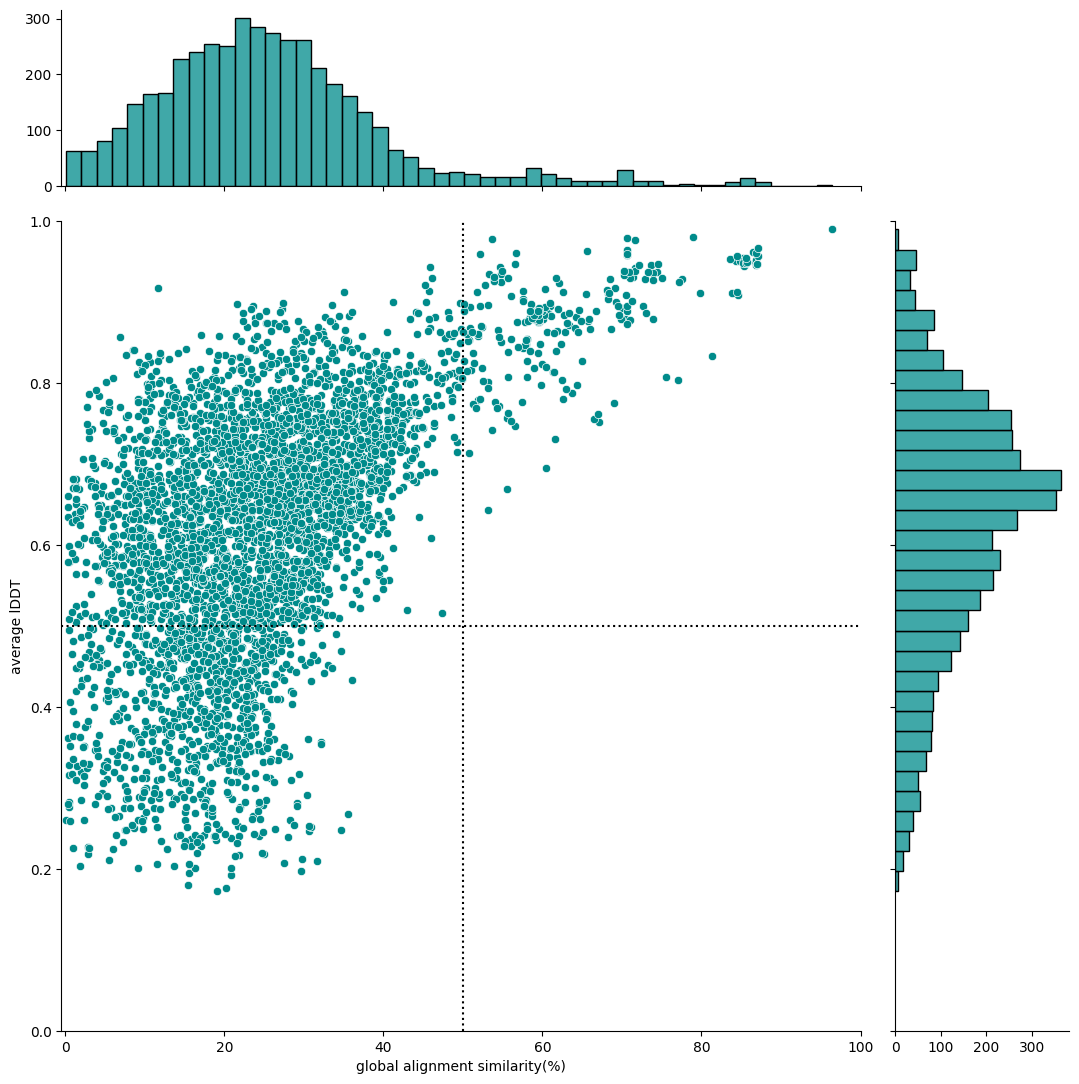

<Figure size 3500x3500 with 0 Axes>

In [24]:
plt.figure(figsize=(8, 8), dpi=500)

sns.jointplot(
    data=foldseek_filter_viz,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("average lDDT") # see foldseek github https://github.com/steineggerlab/foldseek?tab=readme-ov-file#output-search
# plt.axvline(x=25, color="black", linestyle=":")
plt.axvline(x=50, color="black", linestyle=":")
# plt.axvline(x=75, color="black", linestyle=":")
plt.axhline(y=0.5, color="black", linestyle=":")
# plt.axhline(y=color_y, color="black", linestyle=":")
plt.figure(figsize=(7, 7), dpi=500)
plt.show()


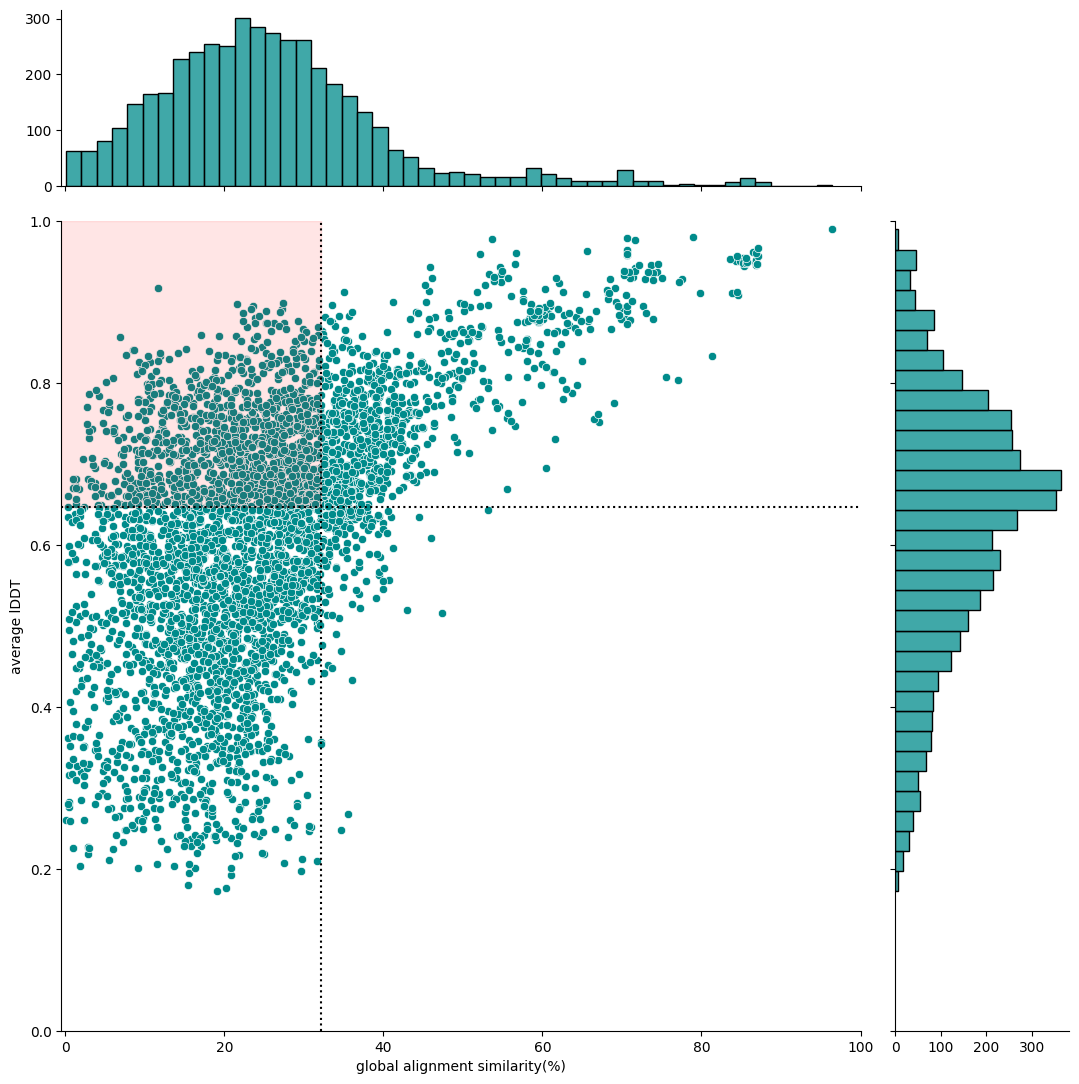

<Figure size 4000x4000 with 0 Axes>

In [25]:
sns.jointplot(
    data=foldseek_filter_viz,
    x="Similarity_percent_needle",
    y="lddt",
    color="darkcyan",
    height=11,
    ratio=4,
    marginal_ticks=True
)

plt.fill_betweenx(
    y=[median_y, 1],
    x1=-0.5,
    x2=third_quartile,
    color="red",
    alpha=0.1
)

# plt.fill_betweenx(
#     y=[median_y, 1],
#     x1=-0.5,
#     x2=third_quartile,
#     color="orange",
#     alpha=0.1
# )

# plt.fill_betweenx(
#     y=[median_y, 1],
#     x1=third_quartile,
#     x2=100,
#     color="blue",
#     alpha=0.1
# )

plt.xlim(-0.5,100)
plt.ylim(0,1)
plt.xlabel("global alignment similarity(%)")
plt.ylabel("average lDDT") # see foldseek github https://github.com/steineggerlab/foldseek?tab=readme-ov-file#output-search
plt.axhline(y=median_y, color="black", linestyle=":")
plt.axvline(x=third_quartile, color="black", linestyle=":")
plt.figure(figsize=(8, 8), dpi=500)
plt.show()


In [26]:
# top hit
foldseek_filter_viz_top = foldseek_filter_viz.filter(
    (pl.col("lddt") >= 0.9) &
    (pl.col("Similarity_percent_needle") > 90)
)

display(foldseek_filter_viz_top)

shape: (1, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Identity_ ┆ Identity_ ┆ Similarit ┆ Similari │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ percent_n ┆ percent_w ┆ y_percent ┆ ty_perce │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ eedle     ┆ ater      ┆ _needle   ┆ nt_water │
│           ┆           ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os05g0367 ┆ Q7XM15    ┆ Q7RTV0    ┆ … ┆ 91.8      ┆ 91.8      ┆ 96.4      ┆ 96.4     │
│ hit-8653  ┆ 000       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

### Scatter Plot with boxplot


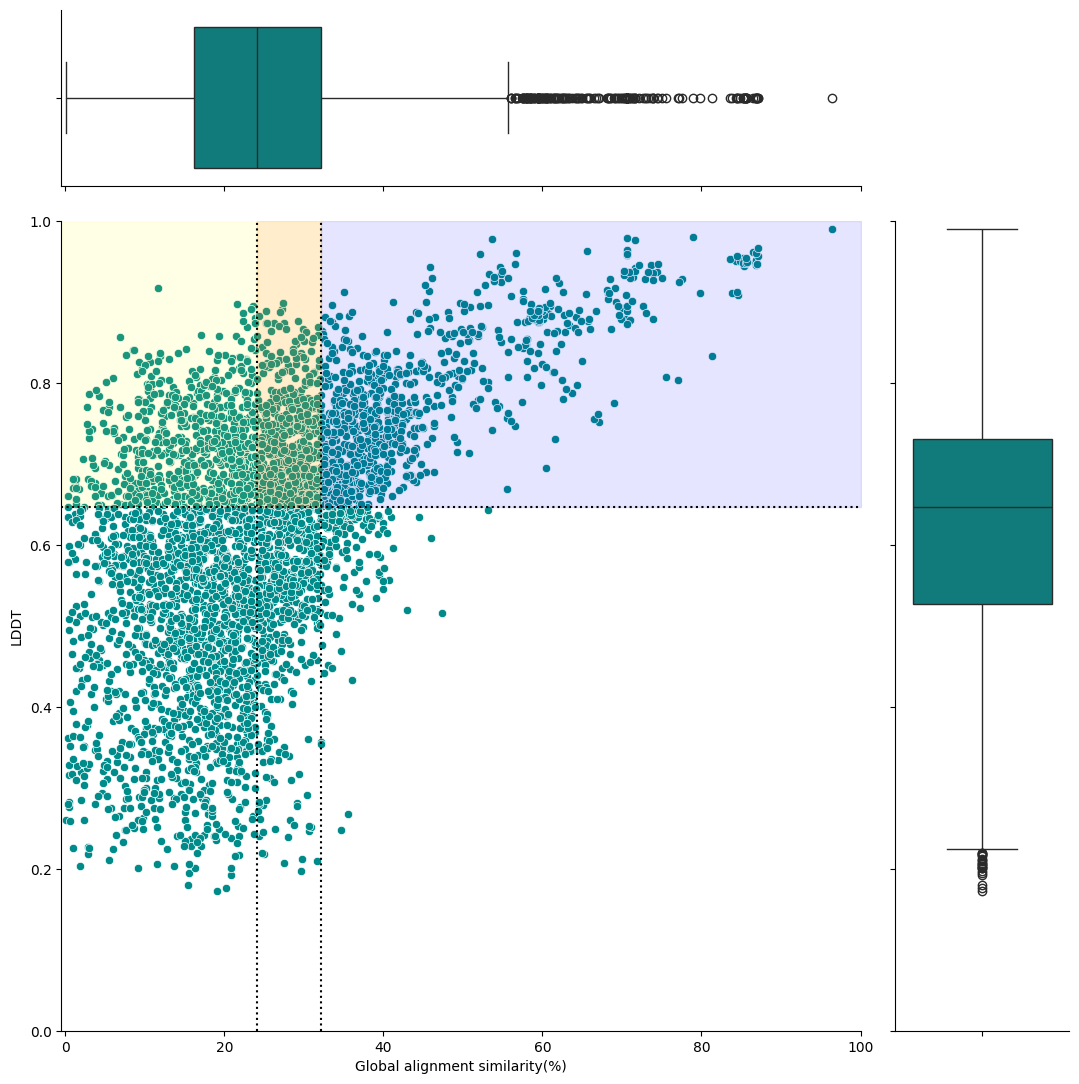

In [27]:
g = sns.JointGrid(
    data=foldseek_filter_viz,
    x="Similarity_percent_needle",
    y="lddt",
    height=11,
    ratio=4,
    marginal_ticks=True
)

# 散布図のプロット
g.plot_joint(sns.scatterplot, color="darkcyan")

# マージナルプロットを箱ひげ図に変更
g.plot_marginals(sns.boxplot, color="darkcyan")

# プロットの設定
g.ax_joint.set_xlim(-0.5, 100)
g.ax_joint.set_ylim(0, 1)
g.ax_joint.set_xlabel("Global alignment similarity(%)")
g.ax_joint.set_ylabel("LDDT")

# 中央値を基にした範囲の塗りつぶし
g.ax_joint.fill_betweenx(
    y=[median_y, 1],
    x1=third_quartile,
    x2=100,
    color="blue",
    alpha=0.1
)

g.ax_joint.fill_betweenx(
    y=[median_y, 1],
    x1=median_x,
    x2=third_quartile,
    color="orange",
    alpha=0.2
)

g.ax_joint.fill_betweenx(
    y=[median_y, 1],
    x1=-0.5,
    x2=median_x,
    color="yellow",
    alpha=0.1
)

g.ax_joint.axvline(x=median_x, color="black", linestyle=":")
g.ax_joint.axhline(y=median_y, color="black", linestyle=":")
g.ax_joint.axvline(x=third_quartile, color="black", linestyle=":")
plt.show()

&nbsp;

&nbsp;

&nbsp;

# Filtering hit

In [29]:
# 条件1: LDDT >= median_y & Similarity_percent_needle > third_quartile
condition3_filter_1 = condition3.filter(
    (pl.col("lddt") >= median_y) & (pl.col("Similarity_percent_needle") > third_quartile)
)

print(condition3_filter_1.select("From").n_unique())
print(condition3_filter_1.select("From").unique().to_series().to_list())
display(condition3_filter_1)

106
['Os05g0156500', 'Os08g0557800', 'Os09g0491772', 'Os05g0367000', 'Os01g0757500', 'Os02g0466400', 'Os03g0267200', 'Os04g0185600', 'Os12g0600100', 'Os02g0710900', 'Os06g0593100', 'Os03g0266300', 'Os11g0244200', 'Os01g0606900', 'Os03g0785900', 'Os04g0136700', 'Os03g0278800', 'Os01g0840100', 'Os07g0246200', 'Os03g0266900', 'Os01g0136000', 'Os05g0223200', 'Os07g0628500', 'Os06g0697200', 'Os06g0716700', 'Os10g0462900', 'Os06g0668200', 'Os10g0419300', 'Os03g0719400', 'Os03g0417700', 'Os02g0580500', 'Os03g0832200', 'Os05g0540300', 'Os05g0595100', 'Os02g0115900', 'Os02g0783700', 'Os04g0107900', 'Os04g0538000', 'Os05g0460475', 'Os03g0267000', 'Os03g0300600', 'Os03g0265600', 'Os10g0320100', 'Os03g0271400', 'Os03g0277300', 'Os04g0530600', 'Os09g0451500', 'Os12g0270900', 'Os11g0106700', 'Os02g0782500', 'Os06g0565200', 'Os01g0136200', 'Os07g0641700', 'Os01g0348900', 'Os07g0549800', 'Os06g0698300', 'Os01g0901600', 'Os03g0131800', 'Os01g0719100', 'Os02g0513100', 'Os01g0135800', 'Os06g0592500', 'Os

shape: (2_019, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ E7EWH7    ┆ … ┆ 87/195    ┆ 44.6      ┆ 99.0      ┆ 93.5     │
│ hit-21    ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q8N6D5    ┆ … ┆ 122/405   ┆ 30.1      ┆ 237.0     ┆ 229.0    │
│ hit-16095 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [30]:
# 条件2: LDDT >= median_y & Similarity_percent_needle <= median_x
condition3_filter_2 = condition3.filter(
    (pl.col("lddt") >= median_y) & (pl.col("Similarity_percent_needle") > median_x)
)

print(condition3_filter_2.select("From").n_unique())
print(condition3_filter_2.select("From").unique().to_series().to_list())
display(condition3_filter_2)

127
['Os05g0540300', 'Os08g0500700', 'Os04g0538000', 'Os02g0580500', 'Os01g0136100', 'Os02g0758000', 'Os01g0184100', 'Os06g0565200', 'Os06g0698300', 'Os04g0445100', 'Os07g0549800', 'Os10g0537500', 'Os02g0824500', 'Os03g0785900', 'Os02g0259900', 'Os09g0491772', 'Os01g0136000', 'Os09g0474300', 'Os06g0716700', 'Os03g0292900', 'Os09g0451500', 'Os08g0278900', 'Os10g0419300', 'Os02g0649300', 'Os12g0106000', 'Os07g0628500', 'Os03g0218500', 'Os03g0817100', 'Os04g0530600', 'Os02g0783700', 'Os03g0266900', 'Os11g0244200', 'Os01g0105800', 'Os03g0268600', 'Os05g0460000', 'Os01g0136200', 'Os03g0796000', 'Os01g0606900', 'Os05g0373900', 'Os03g0271400', 'Os01g0348900', 'Os11g0303800', 'Os03g0832200', 'Os06g0253100', 'Os06g0697200', 'Os11g0106700', 'Os03g0426900', 'Os01g0699400', 'Os01g0901600', 'Os04g0107900', 'Os10g0159033', 'Os03g0267200', 'Os03g0277300', 'Os05g0519700', 'Os03g0245800', 'Os05g0223200', 'Os05g0460475', 'Os06g0593100', 'Os03g0381300', 'Os06g0726600', 'Os02g0115900', 'Os03g0278800', 'Os

shape: (3_039, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ 84/171    ┆ 49.1      ┆ 91.0      ┆ 84.0     │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q9Y2G4    ┆ … ┆ 386/750   ┆ 51.5      ┆ 198.0     ┆ 192.0    │
│ hit-16162 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q9Y575    ┆ … ┆ 287/596   ┆ 48.2      ┆ 275.5     ┆ 266.0    │
│ hit-16164 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q9Y575    ┆ … ┆ 287/596   ┆ 48.2      ┆ 275.5     ┆ 266.0    │
│ hit-16164 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q9Y575    ┆ … ┆ 287/596   ┆ 48.2      ┆ 275.5     ┆ 266.0    │
│ hit-16164 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q9Y575    ┆ … ┆ 287/596   ┆ 48.2      ┆ 275.5     ┆ 266.0    │
│ hit-16164 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [33]:
condition3_filter_3 = condition3.filter(
    ((pl.col("lddt") >= median_y) &
    (pl.col("Similarity_percent_needle") <= median_x)) &
    (~pl.col("From").is_in(condition3_filter_2.select("From").to_series().to_list())) &  # リストに変換
    (~pl.col("foldseek hit").is_in(condition3_filter_2.select("foldseek hit").to_series().to_list()))  # リストに変換
)

print(condition3_filter_3.select("From").n_unique())
print(condition3_filter_3.select("From").unique().to_series().to_list())
display(condition3_filter_3)

19
['Os07g0675200', 'Os10g0532300', 'Os03g0156600', 'Os09g0526600', 'Os01g0183300', 'Os08g0374600', 'Os08g0546800', 'Os10g0373400', 'Os02g0668000', 'Os01g0184050', 'Os09g0526650', 'Os03g0168100', 'Os02g0464550', 'Os03g0296200', 'Os04g0589800', 'Os02g0115950', 'Os12g0418600', 'Os08g0544400', 'Os07g0644100']


shape: (95, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0183 ┆ B9ETI3    ┆ O15357    ┆ … ┆ 825/1347  ┆ 61.2      ┆ 276.0     ┆ 254.5    │
│ hit-455   ┆ 300       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0183 ┆ B9ETI3    ┆ O15357    ┆ … ┆ 825/1347  ┆ 61.2      ┆ 276.0     ┆ 254.5    │
│ hit-455   ┆ 300       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ B4DV37    ┆ … ┆ 95/281    ┆ 33.8      ┆ 49.5      ┆ 38.5     │
│ hit-474   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ E7EST6    ┆ … ┆ 259/346   ┆ 74.9      ┆ 41.0      ┆ 28.0     │
│ hit-481   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ E7EST6    ┆ … ┆ 259/346   ┆ 74.9      ┆ 41.0      ┆ 28.0     │
│ hit-481   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os10g0532 ┆ Q8LN41    ┆ A0A669KB2 ┆ … ┆ 408/542   ┆ 75.3      ┆ 45.0      ┆ 32.0     │
│ hit-14326 ┆ 300       ┆           ┆ 1         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0418 ┆ Q2QST8    ┆ E9PLH3    ┆ … ┆ 98/175    ┆ 56.0      ┆ 44.5      ┆ 36.5     │
│ hit-15249 ┆ 600       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0418 ┆ Q2QST8    ┆ P53567    ┆ … ┆ 204/233   ┆ 87.6      ┆ 34.0      ┆ 23.0     │
│ hit-15250 ┆ 600       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0418 ┆ Q2QST8    ┆ P53567    ┆ … ┆ 204/233   ┆ 87.6      ┆ 34.0      ┆ 23.0     │
│ hit-15250 ┆ 600       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0418 ┆ Q2QST8    ┆ P53567    ┆ … ┆ 204/233   ┆ 87.6      ┆ 34.0      ┆ 23.0     │
│ hit-15250 ┆ 600       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [35]:
condition3_filter_4 = condition3.filter(
    (pl.col("lddt") >= median_y) & (pl.col("Similarity_percent_needle") <= third_quartile) &
    (~pl.col("From").is_in(condition3_filter_1.select("From").to_series().to_list())) &  # リストに変換
    (~pl.col("foldseek hit").is_in(condition3_filter_1.select("foldseek hit").to_series().to_list()))  # リストに変換
)

print(condition3_filter_4.select("From").n_unique())
print(condition3_filter_4.select("From").unique().to_series().to_list())
display(condition3_filter_4)

40
['Os02g0464550', 'Os01g0183300', 'Os05g0129900', 'Os08g0546800', 'Os03g0168100', 'Os10g0159033', 'Os08g0464000', 'Os07g0675200', 'Os12g0478200', 'Os02g0668000', 'Os03g0817100', 'Os11g0303800', 'Os02g0259900', 'Os11g0601700', 'Os03g0296200', 'Os04g0589800', 'Os10g0532300', 'Os11g0506800', 'Os12g0418600', 'Os02g0115950', 'Os03g0796000', 'Os08g0544400', 'Os01g0184050', 'Os03g0426900', 'Os02g0649300', 'Os10g0537500', 'Os03g0292900', 'Os08g0374600', 'Os02g0758000', 'Os08g0117900', 'Os07g0154100', 'Os02g0711300', 'Os03g0156600', 'Os09g0526600', 'Os08g0546400', 'Os07g0644100', 'Os10g0373400', 'Os09g0526650', 'Os02g0181900', 'Os04g0445100']


shape: (385, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0183 ┆ B9ETI3    ┆ O15357    ┆ … ┆ 825/1347  ┆ 61.2      ┆ 276.0     ┆ 254.5    │
│ hit-455   ┆ 300       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0183 ┆ B9ETI3    ┆ O15357    ┆ … ┆ 825/1347  ┆ 61.2      ┆ 276.0     ┆ 254.5    │
│ hit-455   ┆ 300       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ B4DV37    ┆ … ┆ 95/281    ┆ 33.8      ┆ 49.5      ┆ 38.5     │
│ hit-474   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ E7EST6    ┆ … ┆ 259/346   ┆ 74.9      ┆ 41.0      ┆ 28.0     │
│ hit-481   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ E7EST6    ┆ … ┆ 259/346   ┆ 74.9      ┆ 41.0      ┆ 28.0     │
│ hit-481   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;

&nbsp;

&nbsp;

# Custom Analysis: Domain Information

In [36]:
# rice domain information
uniprot_info_rice = pl.read_csv(
    query_idmapping_tsv_path,
    separator='\t'
)

domain_info_rice = uniprot_info_rice.select(
    "From",
    "InterPro"
).rename(
    {
        "From": "UniProt Accession",
        "InterPro": "InterPro_rice"
    }
).with_columns(
    pl.col("InterPro_rice").str.strip_suffix(";")
).with_columns(
    pl.col("InterPro_rice").str.split(";").cast(pl.List(pl.Utf8))
)

# human domain information
uniprot_info_human = pl.read_csv(
    target_idmapping_tsv_path,
    separator='\t'
)

domain_info_human = uniprot_info_human.select(
    "From",
    "InterPro"
).rename(
    {
        "From": "foldseek hit",
        "InterPro": "InterPro_human"
    }
).with_columns(
    pl.col("InterPro_human").str.strip_suffix(";")
).with_columns(
    pl.col("InterPro_human").str.split(";").cast(pl.List(pl.Utf8))
)

display(domain_info_rice)
display(domain_info_human)

shape: (631, 2)
┌───────────────────┬─────────────────────────────────┐
│ UniProt Accession ┆ InterPro_rice                   │
│ ---               ┆ ---                             │
│ str               ┆ list[str]                       │
╞═══════════════════╪═════════════════════════════════╡
│ A0A8J8YF34        ┆ ["IPR050322", "IPR000361", … "… │
│ Q657Z2            ┆ ["IPR050322", "IPR000361", … "… │
│ Q5ZCB1            ┆ ["IPR035995", "IPR000877"]      │
│ Q5ZD53            ┆ ["IPR035995", "IPR000877"]      │
│ A0A0P0UYB2        ┆ ["IPR035995", "IPR000877"]      │
│ …                 ┆ …                               │
│ Q2QND9            ┆ null                            │
│ Q0IM43            ┆ ["IPR002110", "IPR036770", … "… │
│ Q2QML3            ┆ ["IPR002110", "IPR036770", … "… │
│ Q35317            ┆ ["IPR003319"]                   │
│ A0A411LC66        ┆ ["IPR003319"]                   │
└───────────────────┴─────────────────────────────────┘

shape: (5_901, 2)
┌──────────────┬─────────────────────────────────┐
│ foldseek hit ┆ InterPro_human                  │
│ ---          ┆ ---                             │
│ str          ┆ list[str]                       │
╞══════════════╪═════════════════════════════════╡
│ Q9BUE6       ┆ ["IPR050322", "IPR000361", … "… │
│ A0A1B0GTK6   ┆ ["IPR050322", "IPR000361", … "… │
│ Q86U28       ┆ ["IPR000361", "IPR016092", … "… │
│ Q5TBE9       ┆ ["IPR050322", "IPR000361", "IP… │
│ A0A140G945   ┆ ["IPR002068", "IPR001436", … "… │
│ …            ┆ …                               │
│ B4DXL6       ┆ ["IPR051637", "IPR002110", "IP… │
│ F2Z2L2       ┆ ["IPR002110", "IPR036770", … "… │
│ Q5H9P4       ┆ ["IPR049764", "IPR002110", … "… │
│ B4DYP4       ┆ ["IPR002110", "IPR036770", … "… │
│ Q86TV6       ┆ ["IPR051722", "IPR011990", … "… │
└──────────────┴─────────────────────────────────┘

In [37]:
domain_info = condition3.join(
    domain_info_rice,
    on="UniProt Accession",
    how="left",
    coalesce=True,
    validate="m:m"
).join(
    domain_info_human,
    on="foldseek hit",
    how="left",
    coalesce=True,
    validate="m:m"
).with_columns(
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").alias("InterPro ID intersection"),
    pl.col("InterPro_rice").list.set_intersection("InterPro_human").list.len().alias("InterPro ID intersection count")
).sort(
    by=["InterPro ID intersection count"],
    descending=[True]
).with_columns(
    pl.when(
        (pl.col("InterPro_rice").is_null()) | (pl.col("InterPro_human").is_null())
    ).then(
        pl.lit("missing InterPro entry in rice or human")
    ).when(
        pl.col("InterPro ID intersection count") == 0
    ).then(
        pl.lit("no common InterPro ID")
    ).otherwise(
        pl.lit("have common InterPro ID")
    ).alias("InterPro ID intersection tag")
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False]
)

display(domain_info)

shape: (8_495, 48)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ InterPro_ ┆ InterPro  ┆ InterPro  ┆ InterPro │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ human     ┆ ID inters ┆ ID inters ┆ ID inter │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ection    ┆ ection    ┆ section  │
│           ┆           ┆ str       ┆ str       ┆   ┆ list[str] ┆ ---       ┆ count     ┆ tag      │
│           ┆           ┆           ┆           ┆   ┆           ┆ list[str] ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ u32       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ ["IPR0503 ┆ ["IPR0503 ┆ 4         ┆ have     │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆ 22", "IPR ┆ 22", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 000361",  ┆ 000361",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ ["IPR0003 ┆ ["IPR0003 ┆ 4         ┆ have     │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆ 61", "IPR ┆ 61", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 016092",  ┆ 016092",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ ["IPR0003 ┆ ["IPR0003 ┆ 4         ┆ have     │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆ 61", "IPR ┆ 61", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 016092",  ┆ 016092",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ ["IPR0503 ┆ ["IPR0503 ┆ 5         ┆ have     │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆ 22", "IPR ┆ 22", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 000361",  ┆ 000361",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ ["IPR0020 ┆ ["IPR0020 ┆ 2         ┆ have     │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆ 68", "IPR ┆ 68", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 001436",  ┆ 008978"]  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ "IP…      ┆           ┆           ┆ ID       │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q6AZY7    ┆ … ┆ null      ┆ null      ┆ null      ┆ missing  │
│ hit-16201 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ entry in │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ rice…    │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ … ┆ null      ┆ null      ┆ null      ┆ missing  │
│ hit-16204 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ entry in │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ rice…    │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ null      ┆ null      ┆ null      ┆ missing  │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆ InterPro │
│           ┆           ┆           ┆     

### Filtering hit for upset plot

In [38]:
have_domain_info = domain_info.filter(
    (pl.col("InterPro ID intersection tag") == "have common InterPro ID")
)

display(have_domain_info)

shape: (6_311, 48)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ InterPro_ ┆ InterPro  ┆ InterPro  ┆ InterPro │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ human     ┆ ID inters ┆ ID inters ┆ ID inter │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ection    ┆ ection    ┆ section  │
│           ┆           ┆ str       ┆ str       ┆   ┆ list[str] ┆ ---       ┆ count     ┆ tag      │
│           ┆           ┆           ┆           ┆   ┆           ┆ list[str] ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ u32       ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ ["IPR0503 ┆ ["IPR0503 ┆ 4         ┆ have     │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆ 22", "IPR ┆ 22", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 000361",  ┆ 000361",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ ["IPR0003 ┆ ["IPR0003 ┆ 4         ┆ have     │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆ 61", "IPR ┆ 61", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 016092",  ┆ 016092",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ ["IPR0003 ┆ ["IPR0003 ┆ 4         ┆ have     │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆ 61", "IPR ┆ 61", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 016092",  ┆ 016092",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ ["IPR0503 ┆ ["IPR0503 ┆ 5         ┆ have     │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆ 22", "IPR ┆ 22", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 000361",  ┆ 000361",  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆ … "…      ┆           ┆ ID       │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ ["IPR0020 ┆ ["IPR0020 ┆ 2         ┆ have     │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆ 68", "IPR ┆ 68", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 001436",  ┆ 008978"]  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ "IP…      ┆           ┆           ┆ ID       │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ Q9H6T3    ┆ … ┆ ["IPR0519 ┆ ["IPR0119 ┆ 2         ┆ have     │
│ hit-16146 ┆ 100       ┆           ┆           ┆   ┆ 66", "IPR ┆ 90", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 025986",  ┆ 019734"]  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆           ┆           ┆ ID       │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ Q9H6T3    ┆ … ┆ ["IPR0519 ┆ ["IPR0119 ┆ 2         ┆ have     │
│ hit-16146 ┆ 100       ┆           ┆           ┆   ┆ 66", "IPR ┆ 90", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆           ┆   ┆ 025986",  ┆ 019734"]  ┆           ┆ InterPro │
│           ┆           ┆           ┆           ┆   ┆ … "…      ┆           ┆           ┆ ID       │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ Q9H6T3    ┆ … ┆ ["IPR0519 ┆ ["IPR0119 ┆ 2         ┆ have     │
│ hit-16146 ┆ 100       ┆           ┆           ┆   ┆ 66", "IPR ┆ 90", "IPR ┆           ┆ common   │
│           ┆           ┆           ┆     

In [40]:
no_domain_info = domain_info.filter(
    ((pl.col("InterPro ID intersection tag") == "missing InterPro entry in rice or human") |
    (pl.col("InterPro ID intersection tag") == "no common InterPro ID")) &
    (~pl.col("From").is_in(have_domain_info.select("From").to_series().to_list()))
).sort(
    by=["lddt"],
    descending=[True]
)

print(no_domain_info.select("From").n_unique())
print(no_domain_info.select("From").unique().to_series().to_list())
# display(no_domain_info)

53
['Os01g0771200', 'Os04g0600300', 'Os02g0668000', 'Os03g0746900', 'Os10g0159033', 'Os01g0184050', 'Os02g0824500', 'Os02g0259900', 'Os06g0172800', 'Os03g0729000', 'Os12g0418600', 'Os03g0723400', 'Os07g0644100', 'gene-orf224', 'Os06g0356800', 'Os04g0511200', 'Os04g0452500', 'Os05g0151200', 'Os08g0374701', 'Os06g0195800', 'Os01g0224200', 'Os07g0628500', 'Os08g0546400', 'Os07g0529000', 'Os10g0335000', 'Os03g0296200', 'Os12g0111700', 'Os10g0463800', 'Os10g0390900', 'Os08g0546800', 'Os03g0817100', 'Os09g0526650', 'Os10g0334500', 'Os01g0918400', 'Os09g0115900', 'Os07g0675200', 'Os06g0150400', 'Os01g0585100', 'Os10g0373400', 'Os11g0506800', 'Os02g0464550', 'Os10g0537500', 'Os03g0168100', 'Os03g0750100', 'Os11g0594500', 'Os09g0526600', 'Os02g0164000', 'Os03g0727800', 'Os05g0542500', 'Os11g0303800', 'Os02g0115950', 'Os02g0546600', 'Os04g0589800']


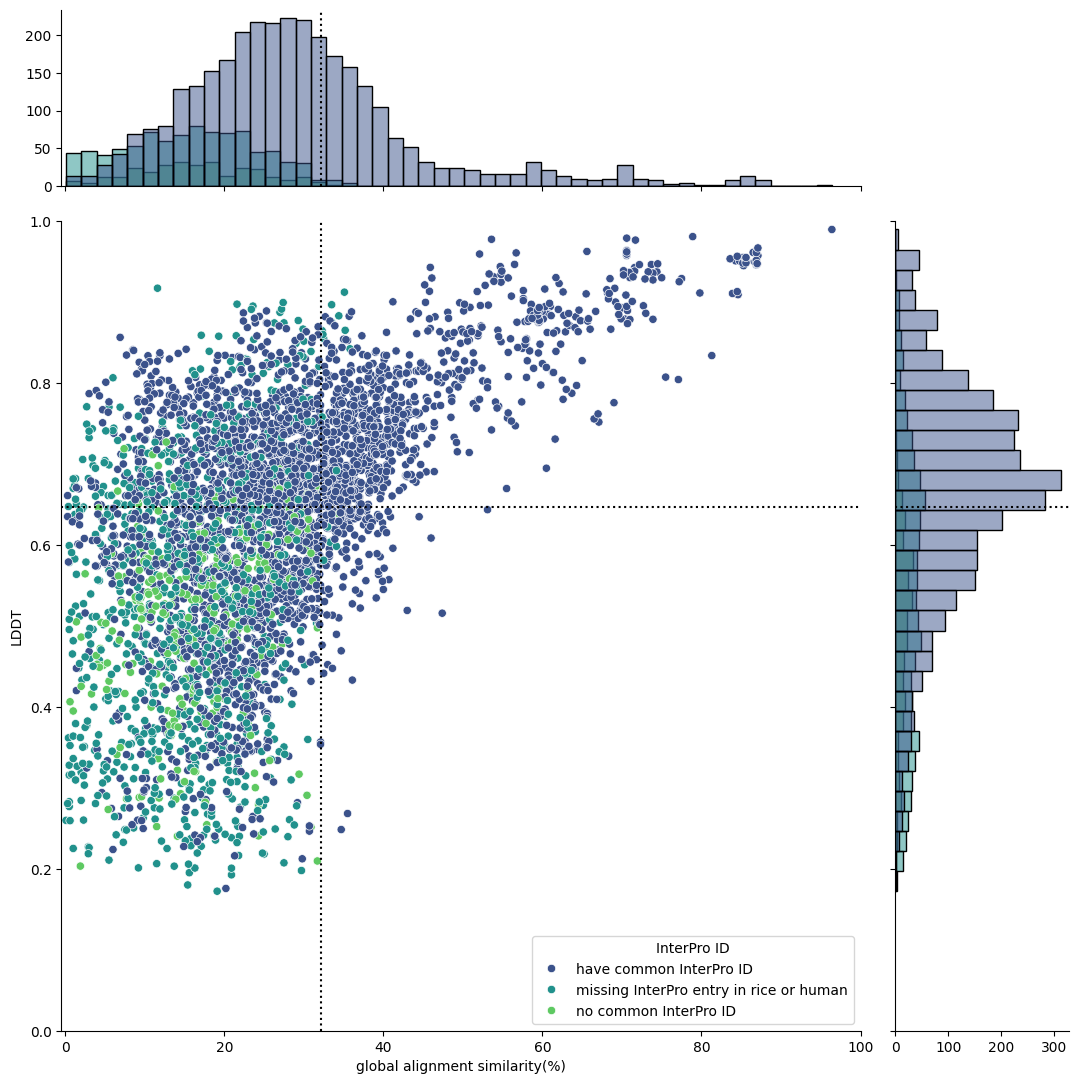

In [41]:
domain_info_viz = domain_info.select(
    "From",
    "UniProt Accession",
    "foldseek hit",
    "qcov",
    "tcov",
    "rmsd",
    "lddt",
    "Identity_percent_needle",
    "Identity_percent_water",
    "Similarity_percent_needle",
    "Similarity_percent_water",
    "InterPro ID intersection tag"
).unique().sort(
    by=["From"],
    descending=[False]
)

g = sns.JointGrid(
    data=domain_info_viz,
    x="Similarity_percent_needle",
    y="lddt",
    hue="InterPro ID intersection tag",
    height=11,
    dropna=False,
    ratio=4,
    palette="viridis",
    marginal_ticks=True
)
g.ax_joint.set_xlim(-0.5,100)
g.ax_joint.set_ylim(0,1)
g.ax_joint.set_xlabel("global alignment similarity(%)")
g.ax_joint.set_ylabel("LDDT")

# g.refline(x=25, color="black", linestyle=":")
# g.refline(x=50, color="black", linestyle=":")
# g.refline(x=75, color="black", linestyle=":")
# g.refline(y=0.5, color="black", linestyle=":")
g.refline(x=third_quartile, color="black", linestyle=":")
g.refline(y=median_y, color="black", linestyle=":")
g.plot(sns.scatterplot, sns.histplot)
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=labels, title='InterPro ID')

plt.show()

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;

&nbsp;





&nbsp;

# Custom Analysis: Ensembl pan-homology information

- Ensembl pan-homologyの情報を追加する

In [42]:
ensembl_pan_homology = pl.read_csv(
    pan_homology_tsv_path,
    separator='\t'
).rename(
    {
        "target_id": "ensembl_gene_id",
        "target_protein_id": "ensembl_protein_id"
    }
).select(
    "From",
    "method_link_type",
    "type",
    "ensembl_gene_id",
    "ensembl_protein_id"
)

print(ensembl_pan_homology.group_by(["From"], maintain_order=True).n_unique())
display(ensembl_pan_homology)

shape: (106, 5)
┌──────────────┬──────────────────┬──────┬─────────────────┬────────────────────┐
│ From         ┆ method_link_type ┆ type ┆ ensembl_gene_id ┆ ensembl_protein_id │
│ ---          ┆ ---              ┆ ---  ┆ ---             ┆ ---                │
│ str          ┆ u32              ┆ u32  ┆ u32             ┆ u32                │
╞══════════════╪══════════════════╪══════╪═════════════════╪════════════════════╡
│ Os01g0105800 ┆ 1                ┆ 1    ┆ 1               ┆ 1                  │
│ Os01g0180800 ┆ 1                ┆ 1    ┆ 4               ┆ 4                  │
│ Os01g0183300 ┆ 1                ┆ 1    ┆ 13              ┆ 13                 │
│ Os01g0184100 ┆ 1                ┆ 1    ┆ 9               ┆ 9                  │
│ Os01g0371200 ┆ 1                ┆ 1    ┆ 14              ┆ 14                 │
│ …            ┆ …                ┆ …    ┆ …               ┆ …                  │
│ Os11g0303800 ┆ 1                ┆ 1    ┆ 14              ┆ 14                 │


shape: (645, 5)
┌──────────────┬─────────────────────┬────────────────────┬─────────────────┬────────────────────┐
│ From         ┆ method_link_type    ┆ type               ┆ ensembl_gene_id ┆ ensembl_protein_id │
│ ---          ┆ ---                 ┆ ---                ┆ ---             ┆ ---                │
│ str          ┆ str                 ┆ str                ┆ str             ┆ str                │
╞══════════════╪═════════════════════╪════════════════════╪═════════════════╪════════════════════╡
│ Os01g0105800 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_one2many  ┆ ENSG00000135070 ┆ ENSP00000365159    │
│ Os01g0180800 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000173110 ┆ ENSP00000310219    │
│ Os01g0180800 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000120694 ┆ ENSP00000318687    │
│ Os01g0180800 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000164070 ┆ ENSP00000296464    │
│ Os01g0180800 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000170606 ┆ ENSP00000302961    │
│ …            ┆ …                   ┆ …                  ┆ …               ┆ …                  │
│ Os12g0600100 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000005175 ┆ ENSP00000005386    │
│ Os12g0600100 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000256061 ┆ ENSP00000323275    │
│ Os12g0600100 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000115282 ┆ ENSP00000233623    │
│ Os12g0600100 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000104450 ┆ ENSP00000373450    │
│ Os12g0600100 ┆ ENSEMBL_ORTHOLOGUES ┆ ortholog_many2many ┆ ENSG00000168439 ┆ ENSP00000305958    │
└──────────────┴─────────────────────┴────────────────────┴─────────────────┴────────────────────┘

In [43]:
display(condition3)

shape: (8_495, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ 84/171    ┆ 49.1      ┆ 91.0      ┆ 84.0     │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q6AZY7    ┆ … ┆ 436/633   ┆ 68.9      ┆ 85.0      ┆ 62.5     │
│ hit-16201 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ … ┆ 461/489   ┆ 94.3      ┆ 34.0      ┆ 21.5     │
│ hit-16204 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 288/470   ┆ 61.3      ┆ 66.5      ┆ 49.5     │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [44]:
ensembl_pan_homology_info = condition3.join(
    ensembl_pan_homology,
    on=["From", "ensembl_protein_id", "ensembl_gene_id"],
    how="left",
    coalesce=True,
    validate="m:m"
).filter(
    (pl.col("method_link_type").is_not_null())
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False]
)

ensembl_pan_homology_info.write_csv(
    "../out/rice_up/ensembl_pan_homology_info.tsv",
    separator="\t"
)

display(ensembl_pan_homology_info)

shape: (289, 45)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Score_wat ┆ Score_nee ┆ method_li ┆ type     │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ er        ┆ dle       ┆ nk_type   ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│           ┆           ┆ str       ┆ str       ┆   ┆ f64       ┆ f64       ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 316.5     ┆ 312.5     ┆ ENSEMBL_O ┆ ortholog │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _one2man │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ y        │
│ foldseek- ┆ Os01g0180 ┆ Q9AQZ5    ┆ O95757    ┆ … ┆ 1564.0    ┆ 1564.0    ┆ ENSEMBL_O ┆ ortholog │
│ hit-401   ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os01g0180 ┆ Q9AQZ5    ┆ P17066    ┆ … ┆ 776.5     ┆ 772.5     ┆ ENSEMBL_O ┆ ortholog │
│ hit-407   ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os01g0180 ┆ Q9AQZ5    ┆ P34932    ┆ … ┆ 1583.0    ┆ 1581.0    ┆ ENSEMBL_O ┆ ortholog │
│ hit-410   ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os01g0180 ┆ Q9AQZ5    ┆ Q92598    ┆ … ┆ 1521.0    ┆ 1521.0    ┆ ENSEMBL_O ┆ ortholog │
│ hit-440   ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q15785    ┆ … ┆ 137.5     ┆ 123.0     ┆ ENSEMBL_O ┆ ortholog │
│ hit-15987 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ O43765    ┆ … ┆ 156.0     ┆ 150.0     ┆ ENSEMBL_O ┆ ortholog │
│ hit-15949 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ P31948    ┆ … ┆ 215.5     ┆ 186.0     ┆ ENSEMBL_O ┆ ortholog │
│ hit-15964 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ Q96EQ0    ┆ … ┆ 136.0     ┆ 128.0     ┆ ENSEMBL_O ┆ ortholog │
│ hit-16119 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
│ foldseek- ┆ Os12g0600 ┆ Q2QML3    ┆ Q9H6T3    ┆ … ┆ 142.5     ┆ 131.0     ┆ ENSEMBL_O ┆ ortholog │
│ hit-16146 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆ RTHOLOGUE ┆ _many2ma │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ S         ┆ ny       │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;

&nbsp;

&nbsp;


# Custom Analysis: HN-score information

- HN-scoreの情報を追加する
- サンプルごとに算出したHN-scoreのデータを追加する

In [45]:
HNscore_rice_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_validate_HN5_rice.tsv",
    separator='\t'
).rename(
    {
        "GENEID": "From"
    }
).drop(
    "positive_contribution",
    "negative_contribution"
)

display(HNscore_rice_sample)

shape: (35_691, 5)
┌──────────────┬──────────┬────────────────────────┬────────────────────────┬───────────────┐
│ From         ┆ HN5(all) ┆ positive_samples_count ┆ negative_samples_count ┆ total_samples │
│ ---          ┆ ---      ┆ ---                    ┆ ---                    ┆ ---           │
│ str          ┆ i64      ┆ i64                    ┆ i64                    ┆ i64           │
╞══════════════╪══════════╪════════════════════════╪════════════════════════╪═══════════════╡
│ Os04g0107900 ┆ 255      ┆ 13                     ┆ 2                      ┆ 15            │
│ Os01g0136100 ┆ 245      ┆ 12                     ┆ 1                      ┆ 15            │
│ Os02g0259900 ┆ 238      ┆ 10                     ┆ 1                      ┆ 15            │
│ Os02g0259850 ┆ 237      ┆ 11                     ┆ 2                      ┆ 15            │
│ Os03g0245800 ┆ 237      ┆ 9                      ┆ 2                      ┆ 15            │
│ …            ┆ …        ┆ …                      ┆ …                      ┆ …             │
│ Os01g0952800 ┆ -173     ┆ 1                      ┆ 10                     ┆ 15            │
│ Os07g0142100 ┆ -176     ┆ 1                      ┆ 7                      ┆ 15            │
│ Os03g0307200 ┆ -180     ┆ 2                      ┆ 7                      ┆ 15            │
│ Os07g0142200 ┆ -186     ┆ 1                      ┆ 11                     ┆ 15            │
│ Os03g0307300 ┆ -204     ┆ 1                      ┆ 8                      ┆ 15            │
└──────────────┴──────────┴────────────────────────┴────────────────────────┴───────────────┘

In [49]:
hnscore_rice_info = condition3.join(
    HNscore_rice_sample,
    on="From",
    how="left",
    coalesce=True
).sort(
    by=["From", "foldseek hit", "UniProt Accession"],
    descending=[False, False, False]
)

display(hnscore_rice_info)

shape: (8_495, 47)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ HN5(all) ┆ positive_ ┆ negative_ ┆ total_sam │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ ---      ┆ samples_c ┆ samples_c ┆ ples      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ i64      ┆ ount      ┆ ount      ┆ ---       │
│           ┆           ┆ str       ┆ str       ┆   ┆          ┆ ---       ┆ ---       ┆ i64       │
│           ┆           ┆           ┆           ┆   ┆          ┆ i64       ┆ i64       ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 56       ┆ 10        ┆ 3         ┆ 15        │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 56       ┆ 10        ┆ 3         ┆ 15        │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 56       ┆ 10        ┆ 3         ┆ 15        │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 56       ┆ 10        ┆ 3         ┆ 15        │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ … ┆ 218      ┆ 9         ┆ 3         ┆ 15        │
│ hit-5     ┆ 800       ┆           ┆ 9         ┆   ┆          ┆           ┆           ┆           │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …        ┆ …         ┆ …         ┆ …         │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q6AZY7    ┆ … ┆ 45       ┆ 12        ┆ 0         ┆ 15        │
│ hit-16201 ┆ 24        ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q8N799    ┆ … ┆ 45       ┆ 12        ┆ 0         ┆ 15        │
│ hit-16204 ┆ 24        ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 45       ┆ 12        ┆ 0         ┆ 15        │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 45       ┆ 12        ┆ 0         ┆ 15        │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
│ foldseek- ┆ gene-orf2 ┆ Q35317    ┆ Q9C0E8    ┆ … ┆ 45       ┆ 12        ┆ 0         ┆ 15        │
│ hit-16206 ┆ 24        ┆           ┆           ┆   ┆          ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘

&nbsp;

&nbsp;

## HN-score information (human and mouse)

- 先にfoldseekでヒットしたUniProt IDに対応するデータをフィルタリングしておく

In [46]:
HNscore_human_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_human_checked_up.tsv",
    separator="\t"
).drop(
    "positive_contribution_human",
    "negative_contribution_human"
)

HNscore_mouse_sample = pl.read_csv(
    "../Data/Data_HNscore/HNscore_sample_count_HN5_mouse_checked_up.tsv",
    separator="\t"
).drop(
    "positive_contribution_mouse",
    "negative_contribution_mouse"
)

display(HNscore_human_sample.head())
display(HNscore_mouse_sample.head())

shape: (5, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ uniprot_i ┆ ensembl_p ┆ ensembl_t ┆ ensembl_g ┆ … ┆ HN5(all) ┆ positive_ ┆ negative_ ┆ total_sam │
│ d         ┆ rotein_id ┆ ranscript ┆ ene_id    ┆   ┆ ---      ┆ samples_c ┆ samples_c ┆ ples      │
│ ---       ┆ ---       ┆ _id       ┆ ---       ┆   ┆ i64      ┆ ount_huma ┆ ount_huma ┆ ---       │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆          ┆ n         ┆ n         ┆ i64       │
│           ┆           ┆ str       ┆           ┆   ┆          ┆ ---       ┆ ---       ┆           │
│           ┆           ┆           ┆           ┆   ┆          ┆ i64       ┆ i64       ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ P17066    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 245      ┆ 27        ┆ 0         ┆ 30        │
│           ┆ 310219    ┆ 309758    ┆ 173110    ┆   ┆          ┆           ┆           ┆           │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 239      ┆ 27        ┆ 0         ┆ 30        │
│           ┆ 364802    ┆ 375651    ┆ 204389    ┆   ┆          ┆           ┆           ┆           │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 239      ┆ 27        ┆ 0         ┆ 30        │
│           ┆ 382915    ┆ 400040    ┆ 215328    ┆   ┆          ┆           ┆           ┆           │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 239      ┆ 27        ┆ 0         ┆ 30        │
│           ┆ 404524    ┆ 430065    ┆ 235941    ┆   ┆          ┆           ┆           ┆           │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 239      ┆ 27        ┆ 0         ┆ 30        │
│           ┆ 408907    ┆ 433487    ┆ 234475    ┆   ┆          ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘

shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ uniprot_i ┆ ensembl_p ┆ ensembl_t ┆ ensembl_g ┆ … ┆ HN5(all) ┆ positive_ ┆ negative_ ┆ total_sam │
│ d         ┆ rotein_id ┆ ranscript ┆ ene_id    ┆   ┆ ---      ┆ samples_c ┆ samples_c ┆ ples      │
│ ---       ┆ ---       ┆ _id       ┆ ---       ┆   ┆ i64      ┆ ount_mous ┆ ount_mous ┆ ---       │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆          ┆ e         ┆ e         ┆ i64       │
│           ┆           ┆ str       ┆           ┆   ┆          ┆ ---       ┆ ---       ┆           │
│           ┆           ┆           ┆           ┆   ┆          ┆ i64       ┆ i64       ┆           │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ A0A0G2JIW ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 149      ┆ 25        ┆ 0         ┆ 30        │
│ 1         ┆ 387691    ┆ 417199    ┆ 232804    ┆   ┆          ┆           ┆           ┆           │
│ A0A0G2JIW ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 149      ┆ 25        ┆ 0         ┆ 30        │
│ 1         ┆ 402651    ┆ 458062    ┆ 212866    ┆   ┆          ┆           ┆           ┆           │
│ A0A0G2JIW ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 149      ┆ 25        ┆ 0         ┆ 30        │
│ 1         ┆ 442789    ┆ 545241    ┆ 224501    ┆   ┆          ┆           ┆           ┆           │
│ P0DMV9    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 149      ┆ 25        ┆ 0         ┆ 30        │
│           ┆ 364801    ┆ 375650    ┆ 204388    ┆   ┆          ┆           ┆           ┆           │
│ P0DMV9    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 149      ┆ 25        ┆ 0         ┆ 30        │
│           ┆ 375399    ┆ 391555    ┆ 212866    ┆   ┆          ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘

In [47]:
HNscore_hm_combine = HNscore_human_sample.join(
    HNscore_mouse_sample,
    on=["uniprot_id", "ensembl_protein_id", "ensembl_transcript_id", "ensembl_gene_id", "hgnc_id"],
    how="left",
    coalesce=True,
    suffix="_mouse"
).select(
    [
        "uniprot_id",
        "ensembl_protein_id",
        "ensembl_transcript_id",
        "ensembl_gene_id",
        "hgnc_id",
        "GENEID",
        "mgi_gene_id",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_mouse",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "total_samples",
        "total_samples_mouse"
    ]
).rename(
    {
        "uniprot_id": "foldseek hit",
        "GENEID": "hgnc_symbol_id",
        "HN5(all)": "HN5(all)_human",
        "total_samples": "total_samples_human"
    }
).unique().sort(
    by=["HN5(all)_human", "HN5(all)_mouse"],
    descending=[True, True]
).filter(
    (pl.col("HN5(all)_human").is_not_null()) &
    (pl.col("HN5(all)_mouse").is_not_null())
)

display(HNscore_hm_combine)

shape: (6_192, 16)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ foldseek  ┆ ensembl_p ┆ ensembl_t ┆ ensembl_g ┆ … ┆ negative_ ┆ negative_ ┆ total_sam ┆ total_sa │
│ hit       ┆ rotein_id ┆ ranscript ┆ ene_id    ┆   ┆ samples_c ┆ samples_c ┆ ples_huma ┆ mples_mo │
│ ---       ┆ ---       ┆ _id       ┆ ---       ┆   ┆ ount_huma ┆ ount_mous ┆ n         ┆ use      │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆ n         ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆           ┆   ┆ ---       ┆ ---       ┆ i64       ┆ i64      │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ V9GZ37    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 0         ┆ 0         ┆ 30        ┆ 30       │
│           ┆ 393259    ┆ 452298    ┆ 234475    ┆   ┆           ┆           ┆           ┆          │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 0         ┆ 0         ┆ 30        ┆ 30       │
│           ┆ 382915    ┆ 400040    ┆ 215328    ┆   ┆           ┆           ┆           ┆          │
│ V9GZ37    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 0         ┆ 0         ┆ 30        ┆ 30       │
│           ┆ 477378    ┆ 608703    ┆ 204389    ┆   ┆           ┆           ┆           ┆          │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 0         ┆ 0         ┆ 30        ┆ 30       │
│           ┆ 364802    ┆ 375651    ┆ 204389    ┆   ┆           ┆           ┆           ┆          │
│ P0DMV8    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 0         ┆ 0         ┆ 30        ┆ 30       │
│           ┆ 406359    ┆ 441618    ┆ 237724    ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ O14879    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 12        ┆ 8         ┆ 30        ┆ 30       │
│           ┆ 505987    ┆ 679781    ┆ 119917    ┆   ┆           ┆           ┆           ┆          │
│ O14879    ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 12        ┆ 8         ┆ 30        ┆ 30       │
│           ┆ 360883    ┆ 371818    ┆ 119917    ┆   ┆           ┆           ┆           ┆          │
│ A0A7P0T7D ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 12        ┆ 8         ┆ 30        ┆ 30       │
│ 6         ┆ 504860    ┆ 681376    ┆ 119917    ┆   ┆           ┆           ┆           ┆          │
│ A0A7P0T7D ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 12        ┆ 8         ┆ 30        ┆ 30       │
│ 6         ┆ 506643    ┆ 681207    ┆ 119917    ┆   ┆           ┆           ┆           ┆          │
│ A0A7P0T85 ┆ ENSP00000 ┆ ENST00000 ┆ ENSG00000 ┆ … ┆ 12        ┆ 8         ┆ 30        ┆ 30       │
│ 5         ┆ 504949    ┆ 680779    ┆ 119917    ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;

In [50]:
hnscore_info = hnscore_rice_info.join(
    HNscore_hm_combine,
    on=["foldseek hit", "ensembl_protein_id", "ensembl_gene_id", "hgnc_symbol_id"], # data type is list[str]
    how="left",
    coalesce=True
).filter(
    pl.col("HN5(all)_human").is_not_null() &
    pl.col("HN5(all)_mouse").is_not_null()
).with_columns(
    (pl.col("positive_samples_count") + pl.col("positive_samples_count_human") + pl.col("positive_samples_count_mouse")).alias("positive_samples_count_all"),
    (pl.col("negative_samples_count") + pl.col("negative_samples_count_human") + pl.col("negative_samples_count_mouse")).alias("negative_samples_count_all")
).select(
    [
        "From",
        "UniProt Accession",
        "foldseek hit",
        "hit label",
        "hgnc_symbol_id",
        "ensembl_gene_id",
        "ensembl_protein_id",
        "GENEID_mouse",
        "HN5(all)",
        "HN5(all)_human",
        "HN5(all)_mouse",
        "positive_samples_count",
        "positive_samples_count_human",
        "positive_samples_count_mouse",
        "negative_samples_count",
        "negative_samples_count_human",
        "negative_samples_count_mouse",
        "total_samples",
        "total_samples_human",
        "total_samples_mouse",
        "positive_samples_count_all",
        "negative_samples_count_all"
    ]
).sort(
    by=["From", "UniProt Accession", "foldseek hit"],
    descending=[False, False, False]
).filter( # 今回最も重要なフィルタリング条件 (positive_samples_count >= 5 & negative_samples_count < 5) & (positive_samples_count_human >= 5 & negative_samples_count_human < 10)
    ((pl.col("positive_samples_count") >= 5) & (pl.col("negative_samples_count") < 5)) &
    ((pl.col("positive_samples_count_human") >= 5) & (pl.col("negative_samples_count_human") < 10)) #&
    # ((pl.col("positive_samples_count_mouse") >= 5) & (pl.col("negative_samples_count_mouse") < 5))
)

display(hnscore_info)

shape: (2_174, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ hit label ┆ … ┆ total_sam ┆ total_sam ┆ positive_ ┆ negative │
│ ---       ┆ Accession ┆ hit       ┆ ---       ┆   ┆ ples_huma ┆ ples_mous ┆ samples_c ┆ _samples │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ n         ┆ e         ┆ ount_all  ┆ _count_a │
│           ┆ str       ┆ str       ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ll       │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆ i64       ┆ i64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆ 9         ┆ hit-5     ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆ 9         ┆ hit-5     ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆ 9         ┆ hit-5     ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ A0A024R3B ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆ 9         ┆ hit-5     ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ E9PHZ2    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 33        ┆ 5        │
│ 800       ┆           ┆           ┆ hit-22    ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ Os12g0600 ┆ Q2QML3    ┆ Q8TF21    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 4        │
│ 100       ┆           ┆           ┆ hit-16105 ┆   ┆           ┆           ┆           ┆          │
│ Os12g0600 ┆ Q2QML3    ┆ Q8TF21    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 4        │
│ 100       ┆           ┆           ┆ hit-16105 ┆   ┆           ┆           ┆           ┆          │
│ Os12g0600 ┆ Q2QML3    ┆ Q8TF21    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 4        │
│ 100       ┆           ┆           ┆ hit-16105 ┆   ┆           ┆           ┆           ┆          │
│ Os12g0600 ┆ Q2QML3    ┆ Q92527    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 7        │
│ 100       ┆           ┆           ┆ hit-16114 ┆   ┆           ┆           ┆           ┆          │
│ Os12g0600 ┆ Q2QML3    ┆ Q96JP0    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 14        ┆ 3        │
│ 100       ┆           ┆           ┆ hit-16121 ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;

&nbsp;


# UpSet plot prototype

In [51]:
foldseek_contents_prototype = {
    "foldseek unique hit pair": condition3["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim≦{third_quartile}%": condition3_filter_4["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim>{third_quartile}%": condition3_filter_1["hit label"].unique().sort().to_list(),
    "Common InterPro ID": have_domain_info["hit label"].unique().sort().to_list(),
    "Ensembl pan-homology": ensembl_pan_homology_info["hit label"].unique().sort().to_list()
}

for key, value in foldseek_contents_prototype.items():
    print(f"{key}: {len(value)}")

upset_data_prototype = from_contents(foldseek_contents_prototype)
display(upset_data_prototype)

foldseek unique hit pair: 4369
lDDT≧0.6467 & Sim≦32.1%: 202
lDDT≧0.6467 & Sim>32.1%: 943
Common InterPro ID: 3183
Ensembl pan-homology: 289


/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
foldseek unique hit pair lDDT≧0.6467 & Sim≦32.1% lDDT≧0.6467 & Sim>32.1% Common InterPro ID Ensembl pan-homology                    
True                     False                   True                    True               False                     foldseek-hit-1
                                                 False                   True               False                   foldseek-hit-100
                                                                                            False                  foldseek-hit-1000
                                                                         False              False                 foldseek-hit-10000
                                                                                            False                 foldseek-hit-10006
...                                                                                                                              ...
                                                                                            False                  foldseek-hit-9986
                                                                         True               False                  foldseek-hit-9988
                                                                         False              False                  foldseek-hit-9989
                                                                         True               False                   foldseek-hit-999
                                                                         False              False                  foldseek-hit-9991

[4369 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

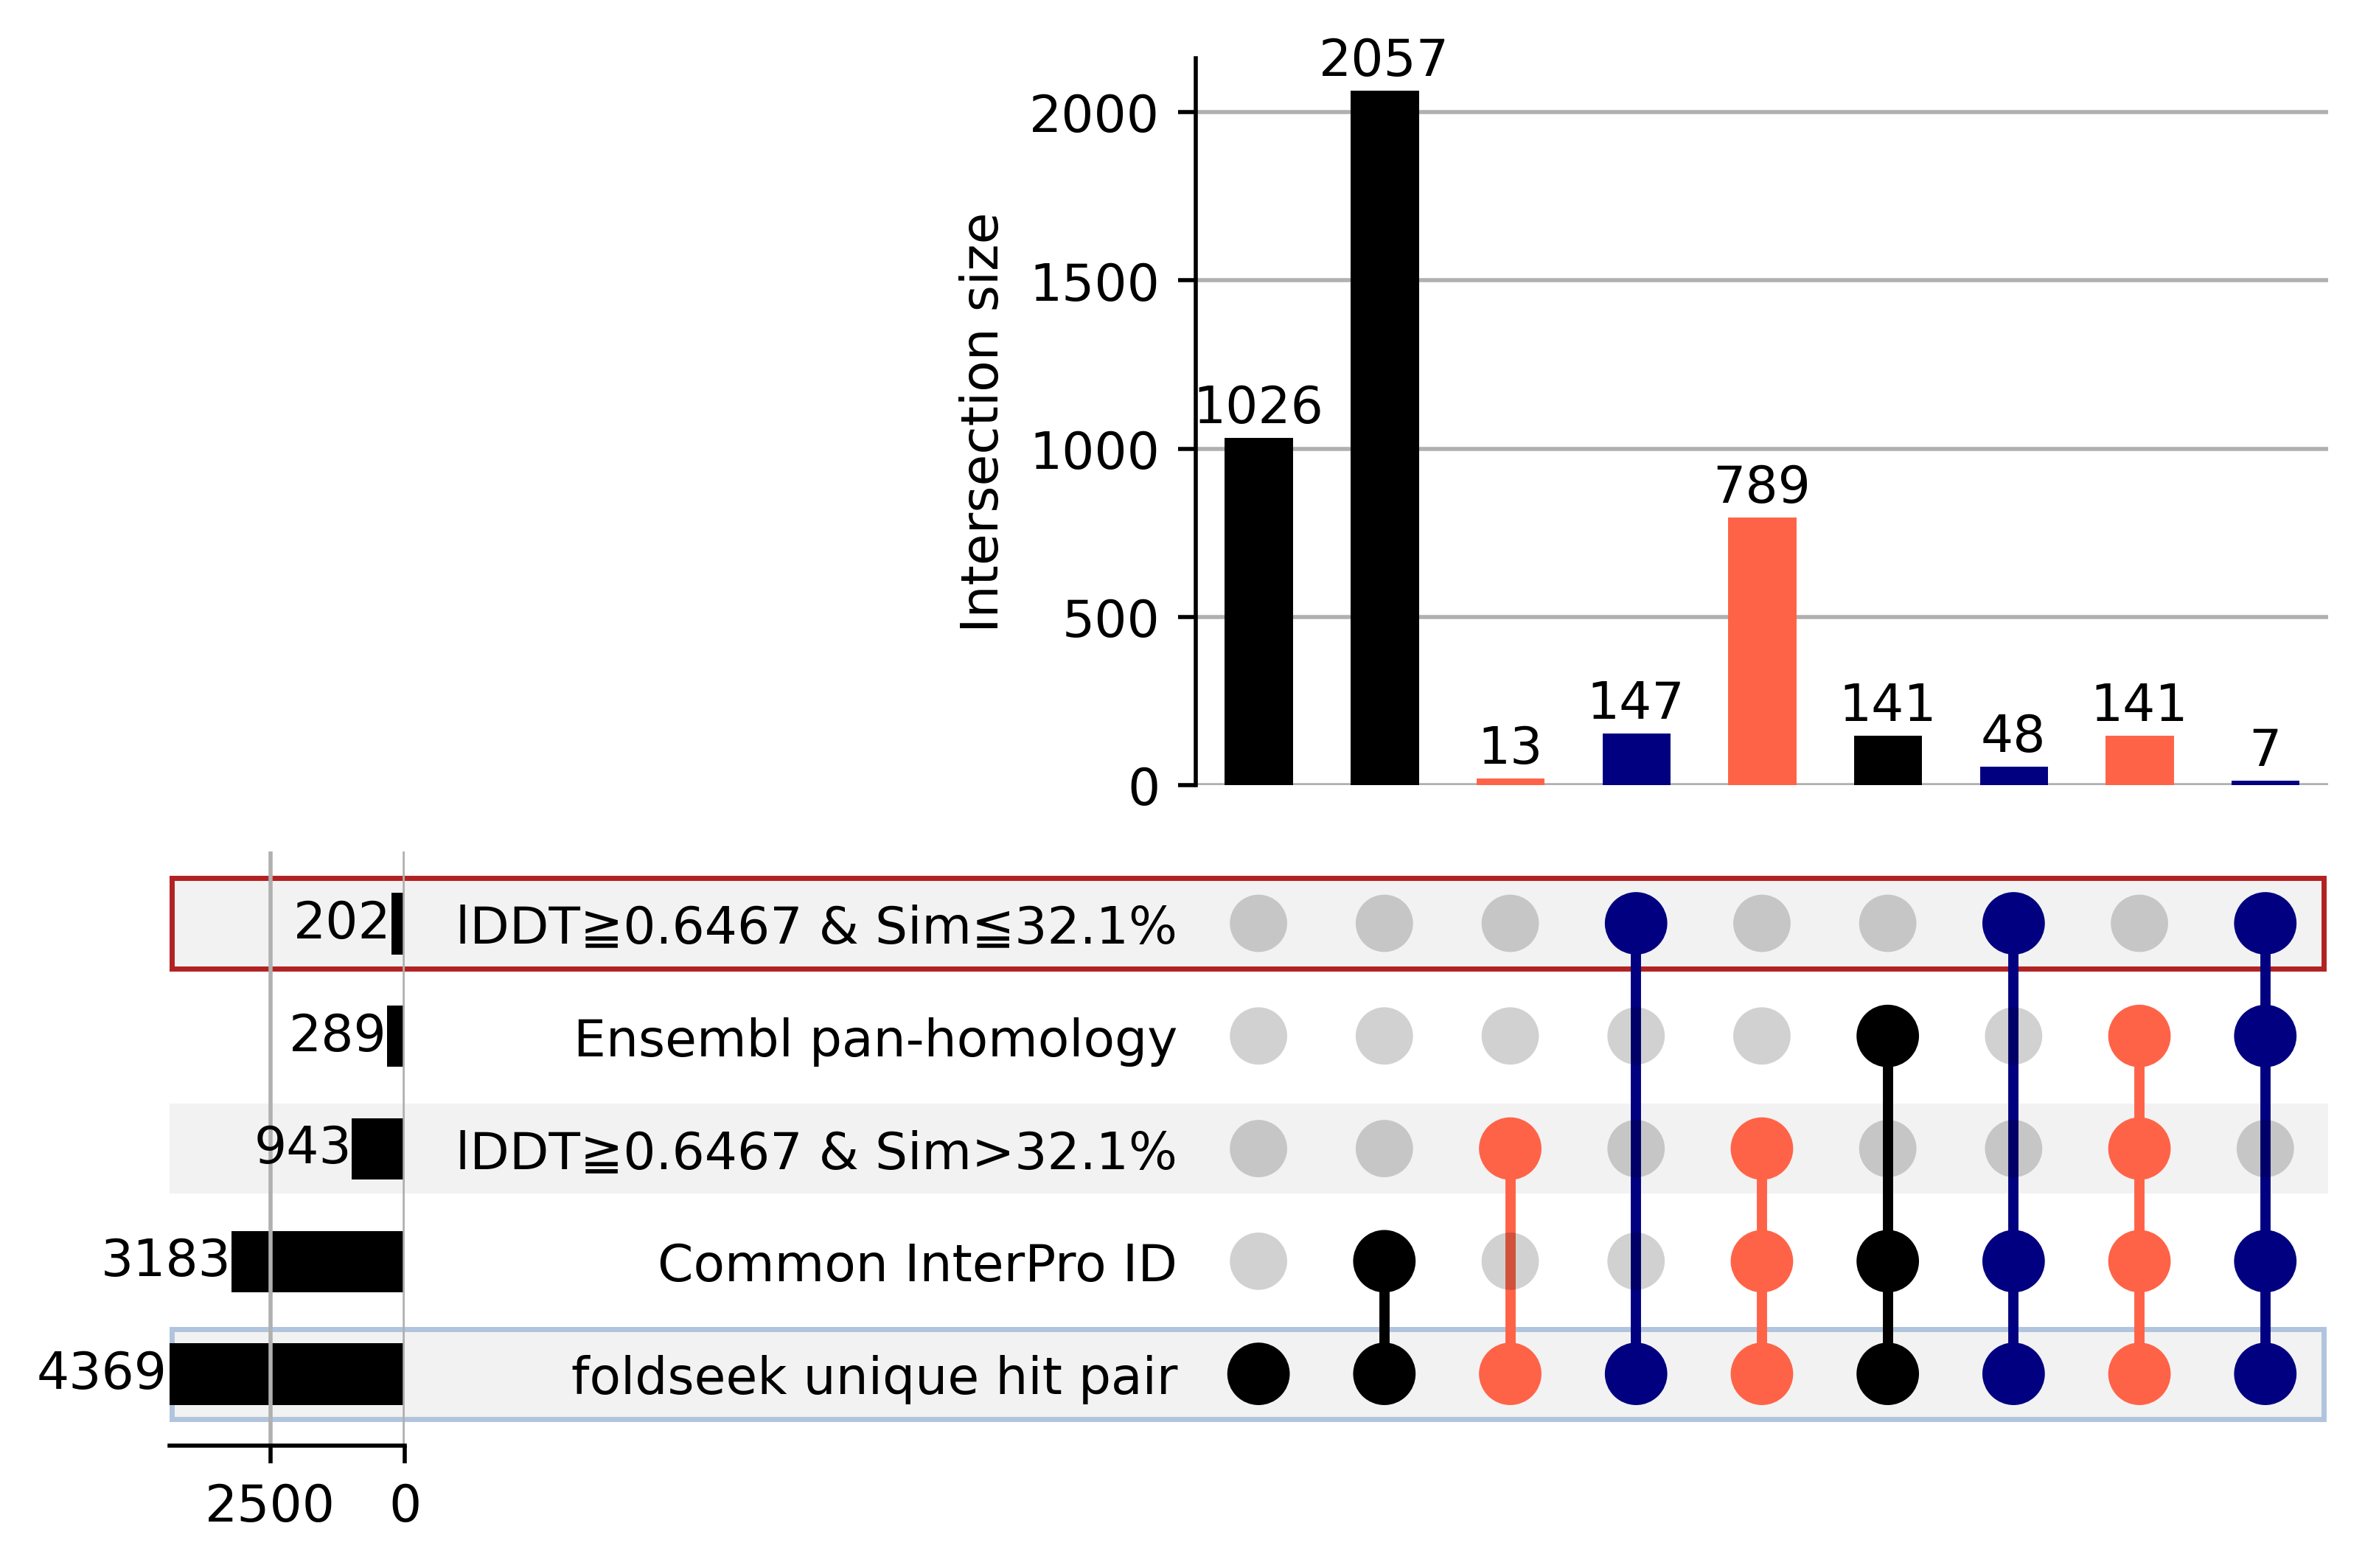

In [52]:
upset_plot = UpSet(
    upset_data_prototype,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim>{third_quartile}%"], 
    facecolor="tomato"
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim≦{third_quartile}%"], 
    facecolor="navy"
)

upset_plot.style_categories(
    "foldseek unique hit pair",
    shading_edgecolor="lightsteelblue",
)

upset_plot.style_categories(
    f"lDDT≧{median_y} & Sim≦{third_quartile}%",
    shading_edgecolor="firebrick",
)


fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

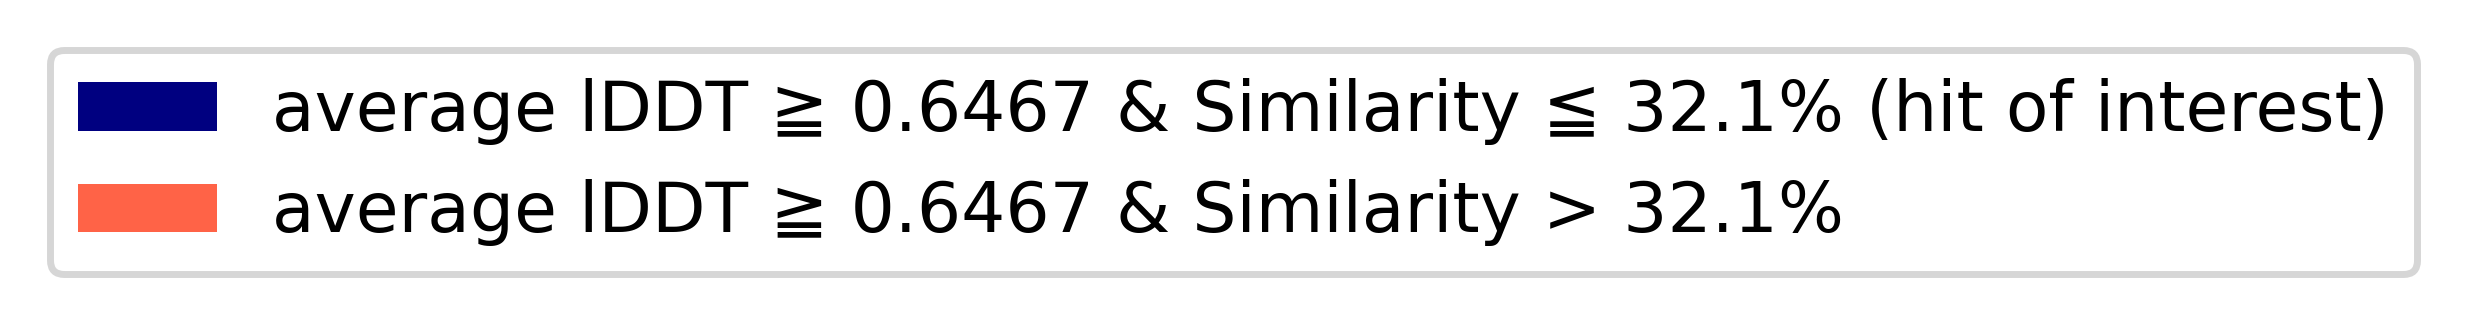

In [53]:
# Create legend independently
legend_elements = [
    Patch(facecolor="navy", label=f"average lDDT ≧ {median_y} & Similarity ≦ {third_quartile}% (hit of interest)"), # 条件4 (別の遺伝子であっても，同じfoldseek hit （例えばHSPB1とか）にヒットしているものも除外)
    Patch(facecolor="tomato", label=f"average lDDT ≧ {median_y} & Similarity > {third_quartile}%") # 条件1
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()

In [54]:
print(condition3_filter_1.select("hit label").n_unique())
display(condition3_filter_1)

943


shape: (2_019, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ A0A1B0GTK ┆ … ┆ 52/141    ┆ 36.9      ┆ 211.5     ┆ 206.5    │
│ hit-1     ┆ 800       ┆           ┆ 6         ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q86U28    ┆ … ┆ 32/162    ┆ 19.8      ┆ 164.5     ┆ 154.5    │
│ hit-3     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0105 ┆ Q657Z2    ┆ Q9BUE6    ┆ … ┆ 15/141    ┆ 10.6      ┆ 316.5     ┆ 312.5    │
│ hit-4     ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0135 ┆ Q943Q3    ┆ E7EWH7    ┆ … ┆ 87/195    ┆ 44.6      ┆ 99.0      ┆ 93.5     │
│ hit-21    ┆ 800       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q8N6D5    ┆ … ┆ 122/405   ┆ 30.1      ┆ 237.0     ┆ 229.0    │
│ hit-16095 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0600 ┆ Q0IM43    ┆ Q96DX5    ┆ … ┆ 159/420   ┆ 37.9      ┆ 249.0     ┆ 231.0    │
│ hit-16116 ┆ 100       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [55]:
print(condition3_filter_4.select("hit label").n_unique())
condition3_filter_4.write_csv(
    "../out/rice_up/rice_up_tmalign_result/condition3_filter_4.tsv",
    separator="\t"
)
condition3_filter_4.write_csv(
    "../out/rice_up/rice_up_tmalign_result/condition3_filter_4.csv",
    separator=","
)

display(condition3_filter_4)

202


shape: (385, 43)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ hit label ┆ From      ┆ UniProt   ┆ foldseek  ┆ … ┆ Gaps_need ┆ Gaps_perc ┆ Score_wat ┆ Score_ne │
│ ---       ┆ ---       ┆ Accession ┆ hit       ┆   ┆ le        ┆ ent_needl ┆ er        ┆ edle     │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ e         ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ str       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ foldseek- ┆ Os01g0183 ┆ B9ETI3    ┆ O15357    ┆ … ┆ 825/1347  ┆ 61.2      ┆ 276.0     ┆ 254.5    │
│ hit-455   ┆ 300       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0183 ┆ B9ETI3    ┆ O15357    ┆ … ┆ 825/1347  ┆ 61.2      ┆ 276.0     ┆ 254.5    │
│ hit-455   ┆ 300       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ B4DV37    ┆ … ┆ 95/281    ┆ 33.8      ┆ 49.5      ┆ 38.5     │
│ hit-474   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ E7EST6    ┆ … ┆ 259/346   ┆ 74.9      ┆ 41.0      ┆ 28.0     │
│ hit-481   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os01g0184 ┆ A0A0N7KCG ┆ E7EST6    ┆ … ┆ 259/346   ┆ 74.9      ┆ 41.0      ┆ 28.0     │
│ hit-481   ┆ 050       ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
│ foldseek- ┆ Os12g0478 ┆ A0A0P0Y9Z ┆ Q9H8W4    ┆ … ┆ 335/365   ┆ 91.8      ┆ 36.0      ┆ 9.5      │
│ hit-15657 ┆ 200       ┆ 0         ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

&nbsp;

&nbsp;

&nbsp;

&nbsp;

In [56]:
foldseek_contents = {
    "foldseek unique hit pair": condition3["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim≦{third_quartile}%": condition3_filter_4["hit label"].unique().sort().to_list(),
    f"lDDT≧{median_y} & Sim>{third_quartile}%": condition3_filter_1["hit label"].unique().sort().to_list(),
    "Common InterPro ID": have_domain_info["hit label"].unique().sort().to_list(),
    "Ensembl pan-homology": ensembl_pan_homology_info["hit label"].unique().sort().to_list(),
    "HN-score sample contribution": hnscore_info["hit label"].unique().sort().to_list()
}

for key, value in foldseek_contents.items():
    print(f"{key}: {len(value)}")

upset_data = from_contents(foldseek_contents)
display(upset_data)

foldseek unique hit pair: 4369
lDDT≧0.6467 & Sim≦32.1%: 202
lDDT≧0.6467 & Sim>32.1%: 943
Common InterPro ID: 3183
Ensembl pan-homology: 289
HN-score sample contribution: 1033


/usr/local/lib/python3.11/site-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


id
foldseek unique hit pair lDDT≧0.6467 & Sim≦32.1% lDDT≧0.6467 & Sim>32.1% Common InterPro ID Ensembl pan-homology HN-score sample contribution                    
True                     False                   True                    True               False                False                             foldseek-hit-1
                                                 False                   True               False                True                            foldseek-hit-100
                                                                                                                 False                          foldseek-hit-1000
                                                                         False              False                False                         foldseek-hit-10000
                                                                                                                 False                         foldseek-hit-10006
...                                                                                                                                                           ...
                                                                                                                 False                          foldseek-hit-9986
                                                                         True               False                False                          foldseek-hit-9988
                                                                         False              False                False                          foldseek-hit-9989
                                                                         True               False                False                           foldseek-hit-999
                                                                         False              False                False                          foldseek-hit-9991

[4369 rows x 1 columns]

/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

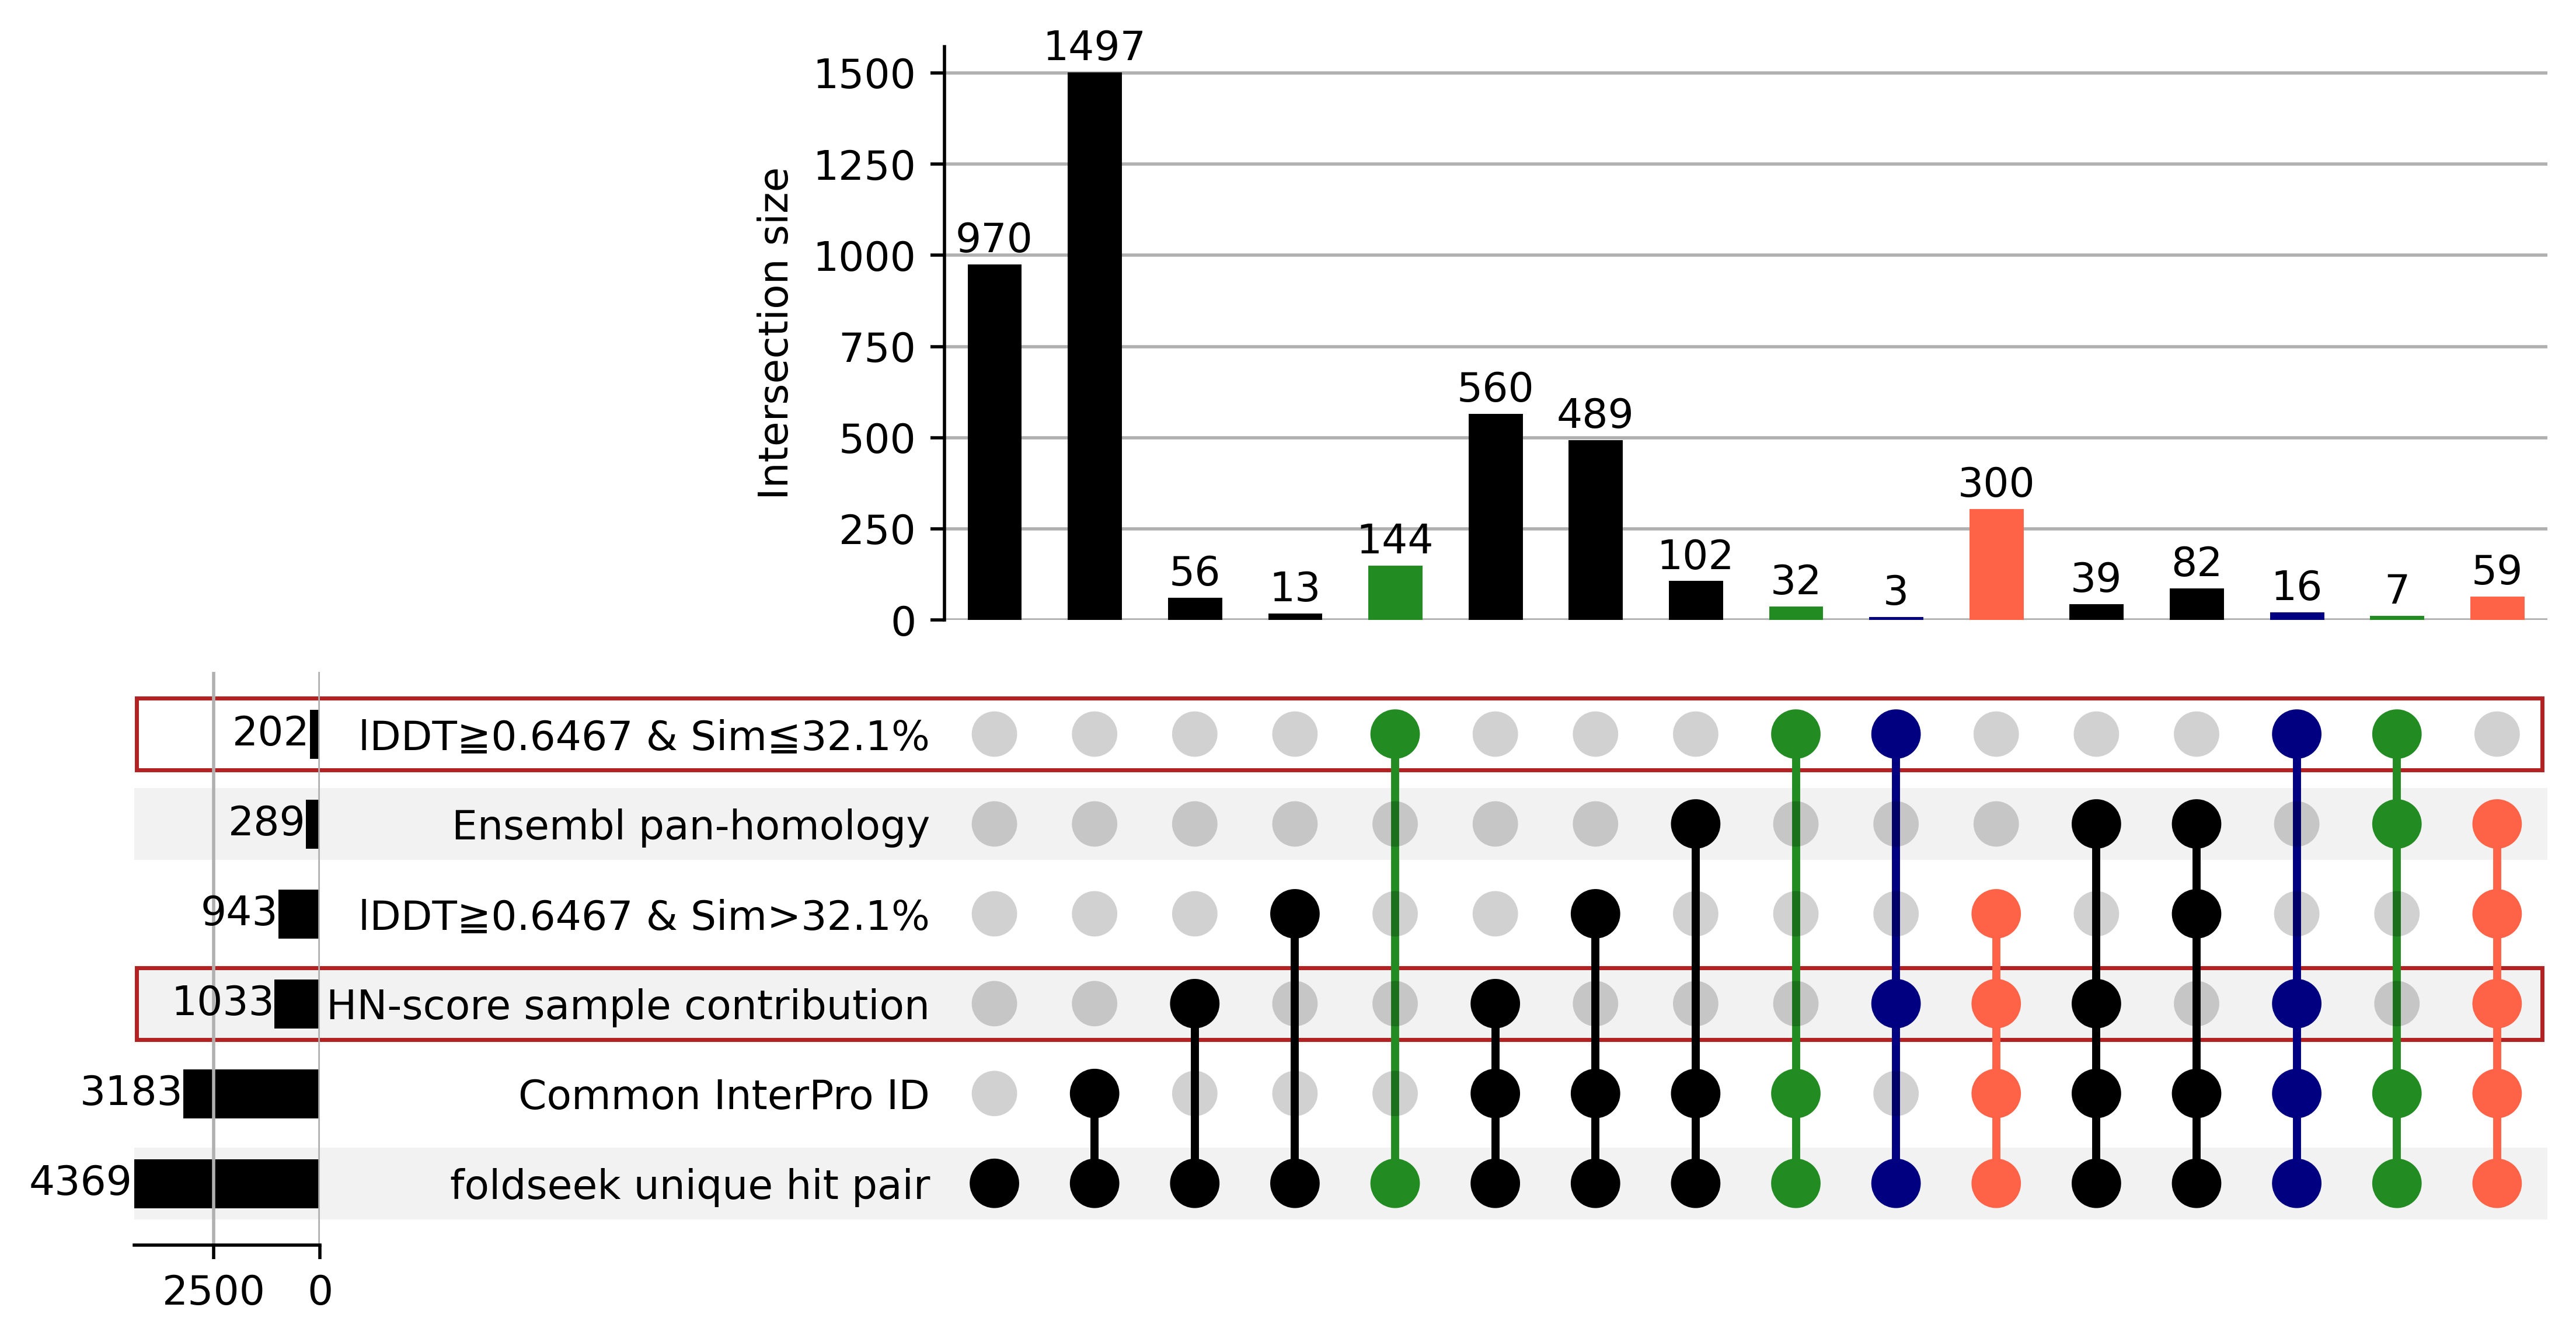

In [57]:
upset_plot = UpSet(
    upset_data,
    orientation='horizontal',
    show_counts="{:d}",
    subset_size='count',
    include_empty_subsets = False
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim≦{third_quartile}%", "HN-score sample contribution"], 
    facecolor="navy"
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim>{third_quartile}%", "HN-score sample contribution"], 
    facecolor="tomato"
)

upset_plot.style_subsets(
    present=[f"lDDT≧{median_y} & Sim≦{third_quartile}%"], 
    absent=["HN-score sample contribution"],
    facecolor="forestgreen"
)

upset_plot.style_categories(
    "foldseek hit",
    shading_edgecolor="lightsteelblue",
)

upset_plot.style_categories(
    f"lDDT≧{median_y} & Sim≦{third_quartile}%",
    shading_edgecolor="firebrick",
)

upset_plot.style_categories(
    "HN-score sample contribution",
    shading_edgecolor="firebrick",
)

fig = plt.figure(figsize=(14, 8), dpi=500)
upset_plot.plot(fig=fig)
plt.show()

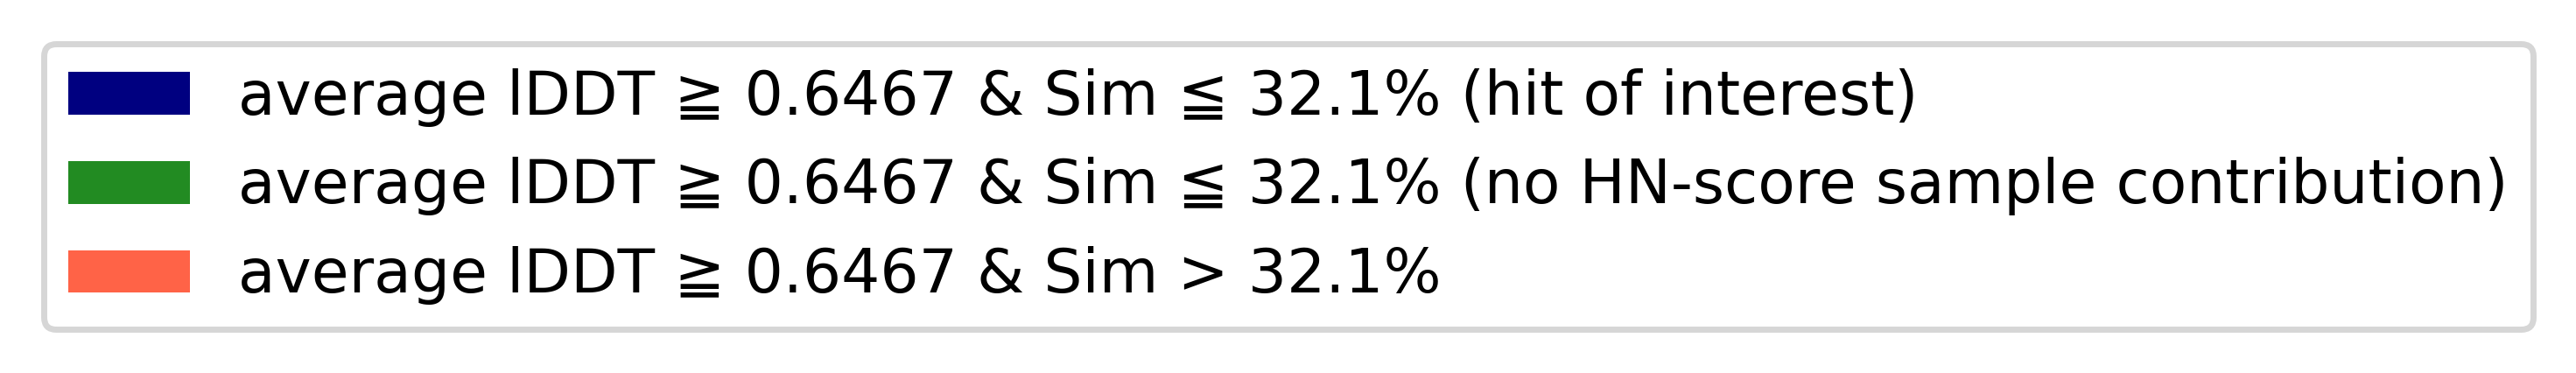

In [58]:
# Create legend independently
legend_elements = [
    Patch(facecolor="navy", label=f"average lDDT ≧ {median_y} & Sim ≦ {third_quartile}% (hit of interest)"),
    Patch(facecolor='forestgreen', label=f"average lDDT ≧ {median_y} & Sim ≦ {third_quartile}% (no HN-score sample contribution)"),
    Patch(facecolor="tomato", label=f"average lDDT ≧ {median_y} & Sim > {third_quartile}%")
]

fig_leg = plt.figure(figsize=(1.5, 0.5), dpi=500)
ax_leg = fig_leg.add_subplot(111)
ax_leg.legend(handles=legend_elements, loc='center')
ax_leg.axis('off') 
plt.show()
# fig_leg.savefig('legend.png', bbox_inches='tight')

&nbsp;

&nbsp;

## Genes of interest

In [59]:
genes_of_interest_hnscore = hnscore_info.filter(
    pl.col("hit label").is_in(condition3_filter_4["hit label"])
    # (pl.col("hit label").is_in(have_domain_info["hit label"])) # Add condition for common InterPro ID
)

print(genes_of_interest_hnscore.select("hit label").n_unique())
pl.Config.set_tbl_rows(40)
display(genes_of_interest_hnscore)

19


shape: (37, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ hit label ┆ … ┆ total_sam ┆ total_sam ┆ positive_ ┆ negative │
│ ---       ┆ Accession ┆ hit       ┆ ---       ┆   ┆ ples_huma ┆ ples_mous ┆ samples_c ┆ _samples │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ n         ┆ e         ┆ ount_all  ┆ _count_a │
│           ┆ str       ┆ str       ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ll       │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆ i64       ┆ i64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os02g0711 ┆ Q0DY72    ┆ Q16082    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 36        ┆ 3        │
│ 300       ┆           ┆           ┆ hit-3413  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0156 ┆ A0A0P0VTE ┆ A0A669KB2 ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 14        ┆ 7        │
│ 600       ┆ 2         ┆ 1         ┆ hit-3724  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0156 ┆ A0A0P0VTE ┆ E5RIM7    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 6        │
│ 600       ┆ 2         ┆           ┆ hit-3733  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0156 ┆ A0A0P0VTE ┆ O00244    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 6        │
│ 600       ┆ 2         ┆           ┆ hit-3739  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0156 ┆ A0A0P0VTE ┆ O00244    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 6        │
│ 600       ┆ 2         ┆           ┆ hit-3739  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0156 ┆ A0A0P0VTE ┆ O00244    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 16        ┆ 6        │
│ 600       ┆ 2         ┆           ┆ hit-3739  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ C9J057    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6213  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ F8WEJ5    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6219  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0796 ┆ Q6F391    ┆ P08243    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 23        ┆ 5        │
│ 000       ┆           ┆           ┆ hit-6222  ┆   ┆           ┆           ┆           ┆          │
│ Os03g0817 ┆ B9F6Z0    ┆ P21145    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 18        ┆ 7        │
│ 100       ┆           ┆           ┆ hit-625

In [60]:
genes_of_interest_hnscore_filter = genes_of_interest_hnscore.select(
    "hit label",
    "From",
    "UniProt Accession",
    "foldseek hit",
    "hgnc_symbol_id"
).unique().sort(
    by=["foldseek hit"],
    descending=False
)

genes_of_interest_hnscore_filter.write_csv(
    "../out/rice_up/rice_up_tmalign_result/genes_of_interest_hnscore_filter.tsv", # or genes_of_interest_hnscore_filter_common_interpro.tsv
    separator="\t"
)

print(genes_of_interest_hnscore_filter.select("hit label").n_unique())
display(genes_of_interest_hnscore_filter)

19


shape: (19, 5)
┌────────────────────┬──────────────┬───────────────────┬──────────────┬────────────────┐
│ hit label          ┆ From         ┆ UniProt Accession ┆ foldseek hit ┆ hgnc_symbol_id │
│ ---                ┆ ---          ┆ ---               ┆ ---          ┆ ---            │
│ str                ┆ str          ┆ str               ┆ str          ┆ str            │
╞════════════════════╪══════════════╪═══════════════════╪══════════════╪════════════════╡
│ foldseek-hit-3724  ┆ Os03g0156600 ┆ A0A0P0VTE2        ┆ A0A669KB21   ┆ ATP7B          │
│ foldseek-hit-14326 ┆ Os10g0532300 ┆ Q8LN41            ┆ A0A669KB21   ┆ ATP7B          │
│ foldseek-hit-6213  ┆ Os03g0796000 ┆ Q6F391            ┆ C9J057       ┆ ASNS           │
│ foldseek-hit-3733  ┆ Os03g0156600 ┆ A0A0P0VTE2        ┆ E5RIM7       ┆ ATOX1          │
│ foldseek-hit-15455 ┆ Os12g0478200 ┆ A0A0P0Y9Z0        ┆ E5RK11       ┆ MTMR7          │
│ foldseek-hit-6219  ┆ Os03g0796000 ┆ Q6F391            ┆ F8WEJ5       ┆ ASNS           │
│ foldseek-hit-12794 ┆ Os08g0464000 ┆ Q6Z201            ┆ G3V438       ┆ AHSA1          │
│ foldseek-hit-15485 ┆ Os12g0478200 ┆ C7JA48            ┆ J3KN75       ┆ TBC1D8B        │
│ foldseek-hit-3739  ┆ Os03g0156600 ┆ A0A0P0VTE2        ┆ O00244       ┆ ATOX1          │
│ foldseek-hit-6222  ┆ Os03g0796000 ┆ Q6F391            ┆ P08243       ┆ ASNS           │
│ foldseek-hit-6257  ┆ Os03g0817100 ┆ B9F6Z0            ┆ P21145       ┆ MAL            │
│ foldseek-hit-15536 ┆ Os12g0478200 ┆ C7JA48            ┆ Q0IIM8       ┆ TBC1D8B        │
│ foldseek-hit-15085 ┆ Os11g0601700 ┆ Q2R1K8            ┆ Q0VG99       ┆ MESP2          │
│ foldseek-hit-3413  ┆ Os02g0711300 ┆ Q0DY72            ┆ Q16082       ┆ HSPB2          │
│ foldseek-hit-10754 ┆ Os07g0154100 ┆ Q69NX5            ┆ Q16518       ┆ RPE65          │
│ foldseek-hit-15557 ┆ Os12g0478200 ┆ C7JA48            ┆ Q53GA4       ┆ PHLDA2         │
│ foldseek-hit-7792  ┆ Os05g0129900 ┆ A0A0P0WHI2        ┆ Q6PID6       ┆ TTC33          │
│ foldseek-hit-14497 ┆ Os10g0537500 ┆ Q8LNN5            ┆ Q96N19       ┆ GPR137         │
│ foldseek-hit-6277  ┆ Os03g0817100 ┆ B9F6Z0            ┆ Q9GZW8       ┆ MS4A7          │
└────────────────────┴──────────────┴───────────────────┴──────────────┴────────────────┘

In [61]:
genes_of_interest_hnscore_2 = hnscore_info.filter(
    pl.col("hit label").is_in(condition3_filter_1["hit label"])
)

print(genes_of_interest_hnscore_2.select("hit label").n_unique())
display(genes_of_interest_hnscore_2)

359


shape: (866, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ From      ┆ UniProt   ┆ foldseek  ┆ hit label ┆ … ┆ total_sam ┆ total_sam ┆ positive_ ┆ negative │
│ ---       ┆ Accession ┆ hit       ┆ ---       ┆   ┆ ples_huma ┆ ples_mous ┆ samples_c ┆ _samples │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ n         ┆ e         ┆ ount_all  ┆ _count_a │
│           ┆ str       ┆ str       ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ll       │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆ i64       ┆ i64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 47        ┆ 4        │
│ 800       ┆           ┆           ┆ hit-26    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0135 ┆ Q943Q3    ┆ Q9BQS6    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 35        ┆ 12       │
│ 800       ┆           ┆           ┆ hit-30    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0136 ┆ E5D3J8    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 49        ┆ 4        │
│ 000       ┆           ┆           ┆ hit-96    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0136 ┆ E5D3J8    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 49        ┆ 4        │
│ 000       ┆           ┆           ┆ hit-96    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0136 ┆ E5D3J8    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 49        ┆ 4        │
│ 000       ┆           ┆           ┆ hit-96    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0136 ┆ E5D3J8    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 49        ┆ 4        │
│ 000       ┆           ┆           ┆ hit-96    ┆   ┆           ┆           ┆           ┆          │
│ Os01g0136 ┆ E5D3J8    ┆ P02511    ┆ foldseek- ┆ … ┆ 30        ┆ 30        ┆ 49        ┆ 4        │
│ 000       ┆           ┆           ┆ hit-96

In [63]:
genes_of_interest_hnscore_2_filter = genes_of_interest_hnscore_2.select(
    "hit label",
    "From",
    "UniProt Accession",
    "foldseek hit",
    "hgnc_symbol_id"
).unique().sort(
    by=["From"],
    descending=False
)

genes_of_interest_hnscore_2_filter.write_csv(
    "../out/rice_up/rice_up_tmalign_result/genes_of_interest_hnscore_2_filter.tsv",
    separator="\t"
)

display(genes_of_interest_hnscore_2_filter)

shape: (362, 5)
┌────────────────────┬──────────────┬───────────────────┬──────────────┬────────────────┐
│ hit label          ┆ From         ┆ UniProt Accession ┆ foldseek hit ┆ hgnc_symbol_id │
│ ---                ┆ ---          ┆ ---               ┆ ---          ┆ ---            │
│ str                ┆ str          ┆ str               ┆ str          ┆ str            │
╞════════════════════╪══════════════╪═══════════════════╪══════════════╪════════════════╡
│ foldseek-hit-30    ┆ Os01g0135800 ┆ Q943Q3            ┆ Q9BQS6       ┆ HSPB9          │
│ foldseek-hit-26    ┆ Os01g0135800 ┆ Q943Q3            ┆ P02511       ┆ CRYAB          │
│ foldseek-hit-98    ┆ Os01g0136000 ┆ E5D3J8            ┆ P04792       ┆ HSPB1          │
│ foldseek-hit-89    ┆ Os01g0136000 ┆ Q943E7            ┆ E9PNH7       ┆ CRYAB          │
│ foldseek-hit-96    ┆ Os01g0136000 ┆ E5D3J8            ┆ P02511       ┆ CRYAB          │
│ foldseek-hit-41    ┆ Os01g0136000 ┆ Q943E7            ┆ A0A024R3B9   ┆ CRYAB          │
│ foldseek-hit-157   ┆ Os01g0136100 ┆ P27777            ┆ E9PNH7       ┆ CRYAB          │
│ foldseek-hit-132   ┆ Os01g0136100 ┆ P27777            ┆ A0A024R3B9   ┆ CRYAB          │
│ foldseek-hit-162   ┆ Os01g0136100 ┆ P27777            ┆ P04792       ┆ HSPB1          │
│ foldseek-hit-161   ┆ Os01g0136100 ┆ P27777            ┆ P02511       ┆ CRYAB          │
│ foldseek-hit-233   ┆ Os01g0136200 ┆ E5D3J7            ┆ P04792       ┆ HSPB1          │
│ foldseek-hit-181   ┆ Os01g0136200 ┆ Q943E6            ┆ A0A024R3B9   ┆ CRYAB          │
│ foldseek-hit-232   ┆ Os01g0136200 ┆ Q943E6            ┆ P02511       ┆ CRYAB          │
│ foldseek-hit-224   ┆ Os01g0136200 ┆ Q943E6            ┆ E9PNH7       ┆ CRYAB          │
│ foldseek-hit-421   ┆ Os01g0180800 ┆ Q9AQZ5            ┆ Q53FA3       ┆ HSPA1L         │
│ foldseek-hit-440   ┆ Os01g0180800 ┆ Q9AQZ5            ┆ Q92598       ┆ HSPH1          │
│ foldseek-hit-404   ┆ Os01g0180800 ┆ Q9AQZ5            ┆ P0DMV9       ┆ HSPA1B         │
│ foldseek-hit-403   ┆ Os01g0180800 ┆ Q9AQZ5            ┆ P0DMV8       ┆ HSPA1A         │
│ foldseek-hit-410   ┆ Os01g0180800 ┆ Q9AQZ5            ┆ P34932       ┆ HSPA4          │
│ foldseek-hit-299   ┆ Os01g0180800 ┆ Q9AQZ5            ┆ A0A7P0TB36   ┆ HSPA5          │
│ …                  ┆ …            ┆ …                 ┆ …            ┆ …              │
│ foldseek-hit-14292 ┆ Os10g0462900 ┆ Q8H903            ┆ P48643       ┆ CCT5           │
│ foldseek-hit-14289 ┆ Os10g0462900 ┆ Q8H903            ┆ P10809       ┆ HSPD1          │
│ foldseek-hit-14560 ┆ Os11g0244200 ┆ Q53M11            ┆ A0A6Q8PGK1   ┆ HSPB1          │
│ foldseek-hit-14559 ┆ Os11g0244200 ┆ Q53M11            ┆ A0A6Q8PFK8   ┆ HSPB1          │
│ foldseek-hit-14580 ┆ Os11g0244200 ┆ Q53M11            ┆ P04792       ┆ HSPB1          │
│ foldseek-hit-15237 ┆ Os12g0270900 ┆ Q2QU81            ┆ Q6IMI4       ┆ SULT6B1        │
│ foldseek-hit-15225 ┆ Os12g0270900 ┆ Q2QU81            ┆ P50225       ┆ SULT1A1        │
│ foldseek-hit-15215 ┆ Os12g0270900 ┆ Q2QU81            ┆ H3BRY5       ┆ SULT1A1        │
│ foldseek-hit-15200 ┆ Os12g0270900 ┆ Q2QU81            ┆ A0A0C4DG03   ┆ SULT6B1        │
│ foldseek-hit-15208 ┆ Os12g0270900 ┆ Q2QU81            ┆ B4DLP0       ┆ SULT1C2        │
│ foldseek-hit-15241 ┆ Os12g0270900 ┆ Q2QU81            ┆ Q9BR01       ┆ SULT4A1        │
│ foldseek-hit-15221 ┆ Os12g0270900 ┆ Q2QU81            ┆ O75897       ┆ SULT1C4        │
│ foldseek-hit-15218 ┆ Os12g0270900 ┆ Q2QU81            ┆ O00338       ┆ SULT1C2        │
│ foldseek-hit-15217 ┆ Os12g0270900 ┆ Q2QU81            ┆ O00204       ┆ SULT2B1        │
│ foldseek-hit-15222 ┆ Os12g0270900 ┆ Q2QU81            ┆ P0DMM9       ┆ SULT1A3        │
│ foldseek-hit-15227 ┆ Os12g0270900 ┆ Q2QU81            ┆ Q06520       ┆ SULT2A1        │
│ foldseek-hit-15223 ┆ Os12g0270900 ┆ Q2QU81            ┆ P0DMN0       ┆ SULT1A4        │
│ foldseek-hit-15226 ┆ Os12g0270900 ┆ Q2QU81            ┆ P50226       ┆ SULT1A2        │
│ foldseek-hit-15199 ┆ O